# Setup

In [125]:
# Make sure that virtual environment is working

import sys
print("Python executable:", sys.executable)


Python executable: /Users/theresahonein/Desktop/terryhonein/Research-HulaHoop/experiments/.venv/bin/python


In [144]:
# Importing packages

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from process_movella import load_movella, get_position, get_steady_hooping_interval, lowpass_filter, estimate_period_autocorr, detrend
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FFMpegWriter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [123]:
# Defining input and output directory

IN_DIR = Path("uploads/2025-07-24 Experiment 2/2025-07-24 Euler Angles")
OUT_DIR = Path("out")

# make the output directory if it does not exit
if not OUT_DIR.exists():
    OUT_DIR.mkdir()

In [124]:
# Constants

# Hoop specifications
d = 83./100     # m, hoop diameter
r = d/2         # m, hoop radius
m = 0.25        # kg, mass of hoop

# Gravity
g = 9.81        # m/s^2, gravitational acceleration

# Time setup
f = 120         # Hz, sampling frequency
dt = 1 / f      # s, sample duration

# Inertias in corotational basis
ICxx = 0.5*m*r**2
ICyy = 0.5*m*r**2
ICzz = m*r**2

# Loading data

In [103]:
# Reading sensor data

# OR: hoop
# OL: right waist
# IB: left waist
# IT: left knee
# IL: left ankle

OL_hoop_file = sorted(list(IN_DIR.glob("OL_*.csv")))[0]
OR_hoop_file = sorted(list(IN_DIR.glob("OR_*.csv")))[0]
IT_hoop_file = sorted(list(IN_DIR.glob("IT_*.csv")))[0]
IL_hoop_file = sorted(list(IN_DIR.glob("IL_*.csv")))[0]
IB_hoop_file = sorted(list(IN_DIR.glob("IB_*.csv")))[0]

lead_time_val = 0
OL_hoop_data = load_movella(OL_hoop_file, lead_time=lead_time_val)
OR_hoop_data = load_movella(OR_hoop_file, lead_time=lead_time_val)
IT_hoop_data = load_movella(IT_hoop_file, lead_time=lead_time_val)
IL_hoop_data = load_movella(IL_hoop_file, lead_time=lead_time_val)
IB_hoop_data = load_movella(IB_hoop_file, lead_time=lead_time_val)

time, OL_accel_x, OL_accel_y, OL_accel_z, OL_phi, OL_theta, OL_psi, OL_wx, OL_wy, OL_wz = OL_hoop_data.T
_, OR_accel_x, OR_accel_y, OR_accel_z, OR_phi, OR_theta, OR_psi, OR_wx, OR_wy, OR_wz = OR_hoop_data.T
_, IT_accel_x, IT_accel_y, IT_accel_z, IT_phi, IT_theta, IT_psi, IT_wx, IT_wy, IT_wz = IT_hoop_data.T
_, IL_accel_x, IL_accel_y, IL_accel_z, IL_phi, IL_theta, IL_psi, IL_wx, IL_wy, IL_wz = IL_hoop_data.T
_, IB_accel_x, IB_accel_y, IB_accel_z, IB_phi, IB_theta, IB_psi, IB_wx, IB_wy, IB_wz = IB_hoop_data.T

# time step
dt = time[1]-time[0]

# Plotting raw angles and their derivatives

@Chrystal: the french songs have different dimensions

In [104]:
print(np.shape(time))
print(np.shape(OL_psi))
print(np.shape(OR_psi))
print(np.shape(IT_psi))
print(np.shape(IL_psi))
print(np.shape(IB_psi))

# padding
def pad(array,size):
    pad_len = size - array.shape[0]
    array = np.concatenate([array, np.full(pad_len, IT_psi[-1])])  # repeat last value
    return array

IT_accel_x = pad(IT_accel_x,5079)
IT_accel_y = pad(IT_accel_y,5079)
IT_accel_z = pad(IT_accel_z,5079)
IT_phi = pad(IT_phi,5079)
IT_theta = pad(IT_theta,5079)
IT_psi = pad(IT_psi,5079)
IT_wx = pad(IT_wx,5079)
IT_wy = pad(IT_wy,5079)
IT_wz = pad(IT_wz,5079)

print(np.shape(IT_psi))


(5079,)
(5079,)
(5079,)
(5058,)
(5079,)
(5079,)
(5079,)


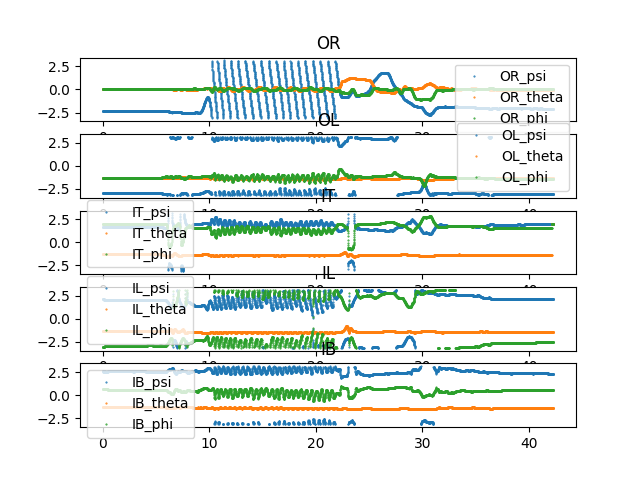

In [105]:
# Plotting raw euler angle data
%matplotlib widget

# re: raw euler
fig_re, ax_re = plt.subplots(5)  # Creates a 3x1 grid of Axes

ax_re[0].set_title('OR')
ax_re[0].plot(time, OR_psi,'.', label='OR_psi', markersize=1)
ax_re[0].plot(time, OR_theta,'.', label='OR_theta', markersize=1)
ax_re[0].plot(time, OR_phi,'.', label='OR_phi', markersize=1)
ax_re[0].legend()

ax_re[1].set_title('OL')
ax_re[1].plot(time, OL_psi,'.', label='OL_psi', markersize=1)
ax_re[1].plot(time, OL_theta,'.', label='OL_theta', markersize=1)
ax_re[1].plot(time, OL_phi,'.', label='OL_phi', markersize=1)
ax_re[1].legend()

ax_re[2].set_title('IT')
ax_re[2].plot(time, IT_psi,'.', label='IT_psi', markersize=1)
ax_re[2].plot(time, IT_theta,'.', label='IT_theta', markersize=1)
ax_re[2].plot(time, IT_phi,'.', label='IT_phi', markersize=1)
ax_re[2].legend()

ax_re[3].set_title('IL')
ax_re[3].plot(time, IL_psi,'.', label='IL_psi', markersize=1)
ax_re[3].plot(time, IL_theta,'.', label='IL_theta', markersize=1)
ax_re[3].plot(time, IL_phi,'.', label='IL_phi', markersize=1)
ax_re[3].legend()

ax_re[4].set_title('IB')
ax_re[4].plot(time, IB_psi,'.', label='IB_psi', markersize=1)
ax_re[4].plot(time, IB_theta,'.', label='IB_theta', markersize=1)
ax_re[4].plot(time, IB_phi,'.', label='IB_phi', markersize=1)
ax_re[4].legend()

Zoom into IT, IL, and IB data. Looks like all angles are periodic with same period. Same for hoop. IT comes in bursts, then does down, IL less no, IB not so. See in later plot that derivative of IB is order 10, whereas derivatives of IT and IL are order 100. 

What does the 3-2-1 Euler angle set look like for the hip? Does it make sense that theta is almost zero?

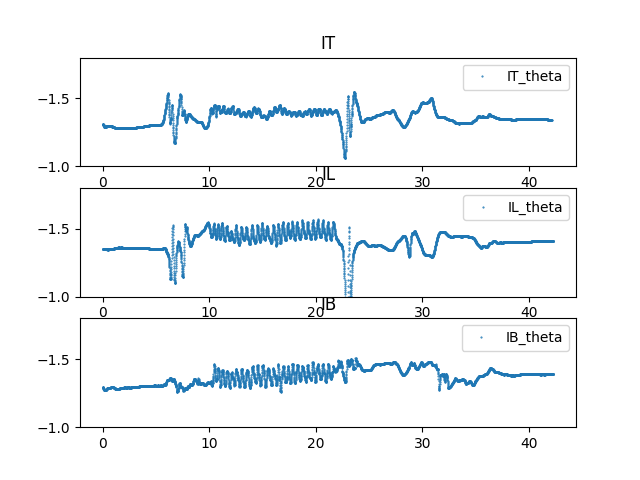

In [106]:
# Plotting theta of the hip on its own
%matplotlib widget

# Plotting raw euler angle data
# th: theta hip
fig_th, ax_th = plt.subplots(3)  # Creates a 3x1 grid of Axes


ax_th[0].set_title('IT')
ax_th[0].plot(time, IT_theta,'.', label='IT_theta', markersize=1)
ax_th[0].set_ylim(-1,-1.8) 
ax_th[0].legend()

ax_th[1].set_title('IL')
ax_th[1].plot(time, IL_theta,'.', label='IL_theta', markersize=1)
ax_th[1].set_ylim(-1,-1.8) 
ax_th[1].legend()

ax_th[2].set_title('IB')
ax_th[2].plot(time, IB_theta,'.', label='IB_theta', markersize=1)
ax_th[2].set_ylim(-1,-1.8) 
ax_th[2].legend()

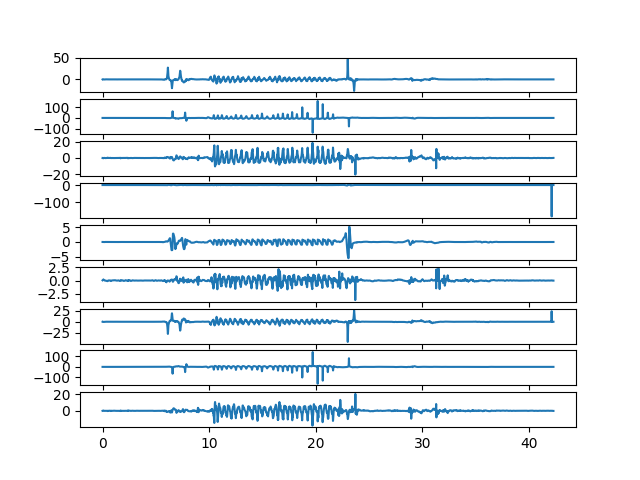

In [107]:
# Derivatives of psi and phi of hip
%matplotlib widget

IT_psi_unwrapped = np.unwrap(IT_psi)
IL_psi_unwrapped = np.unwrap(IL_psi)
IB_psi_unwrapped = np.unwrap(IB_psi)

IT_theta_unwrapped = np.unwrap(IT_theta)
IL_theta_unwrapped = np.unwrap(IL_theta)
IB_theta_unwrapped = np.unwrap(IB_theta)

IT_phi_unwrapped = np.unwrap(IT_phi)
IL_phi_unwrapped = np.unwrap(IL_phi)
IB_phi_unwrapped = np.unwrap(IB_phi)

IT_dpsi_dt = np.gradient(IT_psi_unwrapped, dt)
IL_dpsi_dt = np.gradient(IL_psi_unwrapped, dt)
IB_dpsi_dt = np.gradient(IB_psi_unwrapped, dt)

IT_dtheta_dt = np.gradient(IT_theta_unwrapped, dt)
IL_dtheta_dt = np.gradient(IL_theta_unwrapped, dt)
IB_dtheta_dt = np.gradient(IB_theta_unwrapped, dt)

IT_dphi_dt = np.gradient(IT_phi_unwrapped, dt)
IL_dphi_dt = np.gradient(IL_phi_unwrapped, dt)
IB_dphi_dt = np.gradient(IB_phi_unwrapped, dt)

fig_dhip, ax_dhip = plt.subplots(9)
ax_dhip[0].plot(time, IT_dpsi_dt)
ax_dhip[1].plot(time, IL_dpsi_dt)
ax_dhip[2].plot(time, IB_dpsi_dt)

ax_dhip[3].plot(time, IT_dtheta_dt)
ax_dhip[4].plot(time, IL_dtheta_dt)
ax_dhip[5].plot(time, IB_dtheta_dt)

ax_dhip[6].plot(time, IT_dphi_dt)
ax_dhip[7].plot(time, IL_dphi_dt)
ax_dhip[8].plot(time, IB_dphi_dt)

For the signals on the upper hip (belt), you see bursts of fast motion of the angles psi and psi. The rest of the motion is slow. This is evidenced by the derivatives. Lower hip data looks different.

In the paper `Kinetics of hula hooping: An inverse dynamics analysis by Cluff et al. (2008)`, the authors discuss in their results that there were substantial asychronous abductor moments observed about the hip for both the left and right legs. The abductor moments produced large bursts of positive and negative work making the abductor moment the prime mover during hula hooping.

Our data does not substantiate this result. See my written analysis.

# Determining the interval of steady hula hooping

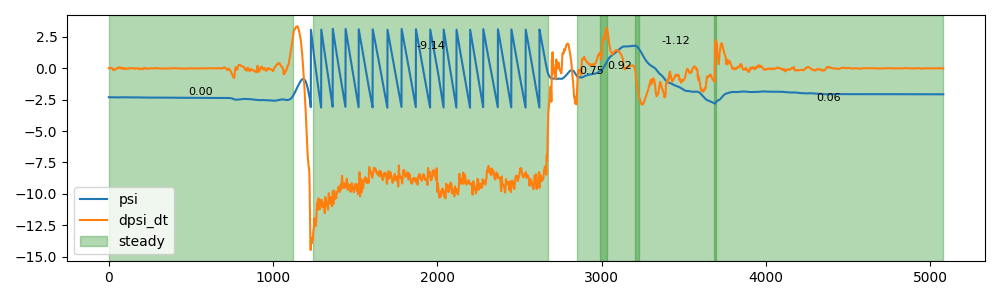

In [108]:
OR_groups, OR_averages = get_steady_hooping_interval(OR_psi, dt=dt, threshold=0.8)

In [109]:
print(OR_groups[1])
t_active = OR_groups[1]
active_slice = slice(*t_active)

(np.int64(1245), np.int64(2671))


We can detect when steady hula hoop motion is happening by looking at the psi-dot time series. psi is almost constant during steady hula hooping. You see how initially the hula hooper turns the hoop opposite to the directions at which it will rotate, then gives a high initial angular velocity. The initial angular velocity psidot will be sustained by the hoop until failure.

# Angular velocities

Text(0.5, 1.0, 'IB: left waist, wz')

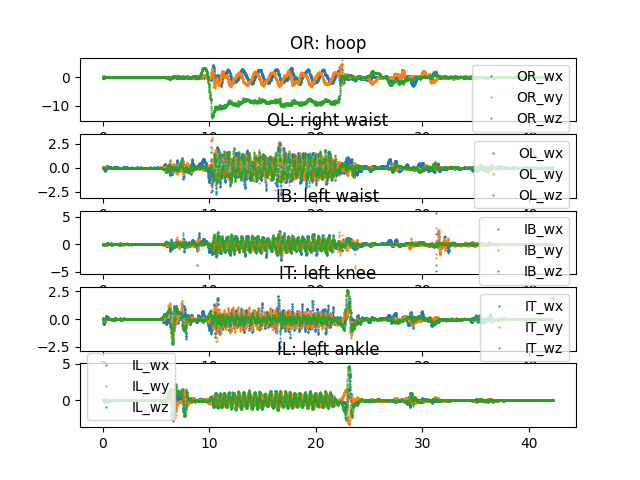

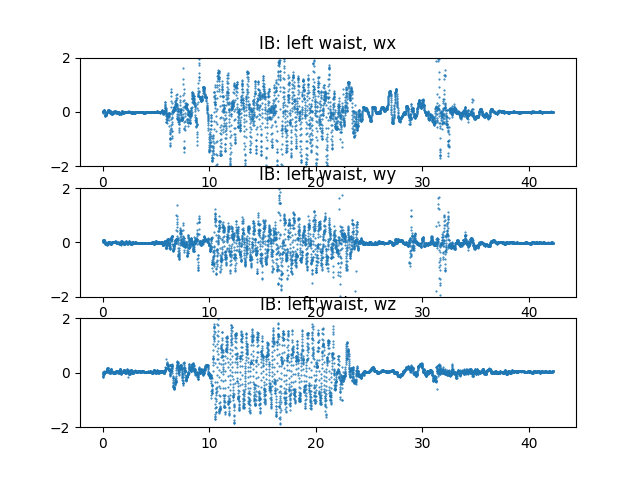

In [110]:
# Plotting angular velocity data
%matplotlib widget

# re: raw euler
fig, ax = plt.subplots(5)  # Creates a 3x1 grid of Axes

ax[0].set_title('OR: hoop')
ax[0].plot(time, OR_wx,'.', label='OR_wx', markersize=1)
ax[0].plot(time, OR_wy,'.', label='OR_wy', markersize=1)
ax[0].plot(time, OR_wz,'.', label='OR_wz', markersize=1)
ax[0].legend()

ax[1].set_title('OL: right waist')
ax[1].plot(time, OL_wx,'.', label='OL_wx', markersize=1)
ax[1].plot(time, OL_wy,'.', label='OL_wy', markersize=1)
ax[1].plot(time, OL_wz,'.', label='OL_wz', markersize=1)
ax[1].legend()

ax[2].set_title('IB: left waist')
ax[2].plot(time, IB_wx,'.', label='IB_wx', markersize=1)
ax[2].plot(time, IB_wy,'.', label='IB_wy', markersize=1)
ax[2].plot(time, IB_wz,'.', label='IB_wz', markersize=1)
ax[2].legend()

ax[3].set_title('IT: left knee')
ax[3].plot(time, IT_wx,'.', label='IT_wx', markersize=1)
ax[3].plot(time, IT_wy,'.', label='IT_wy', markersize=1)
ax[3].plot(time, IT_wz,'.', label='IT_wz', markersize=1)
ax[3].legend()

ax[4].set_title('IL: left ankle')
ax[4].plot(time, IL_wx,'.', label='IL_wx', markersize=1)
ax[4].plot(time, IL_wy,'.', label='IL_wy', markersize=1)
ax[4].plot(time, IL_wz,'.', label='IL_wz', markersize=1)
ax[4].legend()


fig, ax = plt.subplots(3)  # Creates a 3x1 grid of Axes
ax[0].plot(time, IB_wx,'.', label='IB_wx', markersize=1)
ax[0].set_ylim(-2, 2)
ax[0].set_title('IB: left waist, wx')

ax[1].plot(time, IB_wy,'.', label='IB_wy', markersize=1)
ax[1].set_ylim(-2, 2)
ax[1].set_title('IB: left waist, wy')

ax[2].plot(time, IB_wz,'.', label='IB_wz', markersize=1)
ax[2].set_ylim(-2, 2)
ax[2].set_title('IB: left waist, wz')


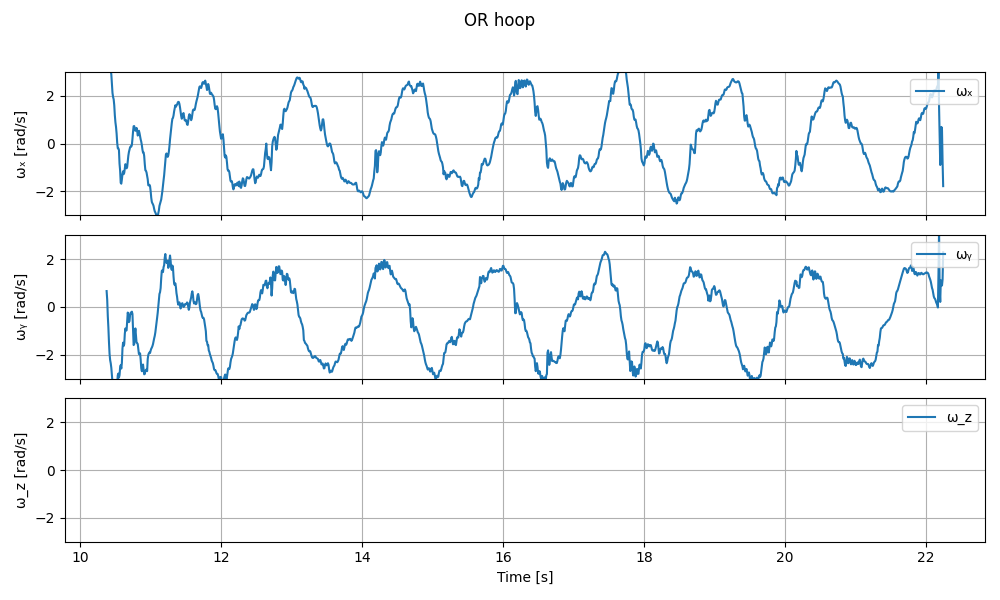

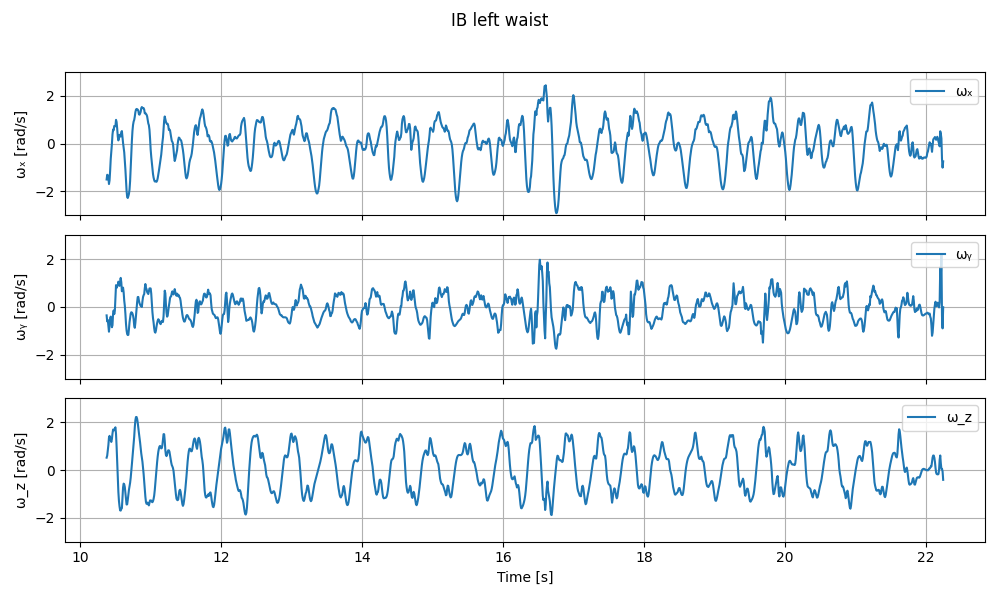

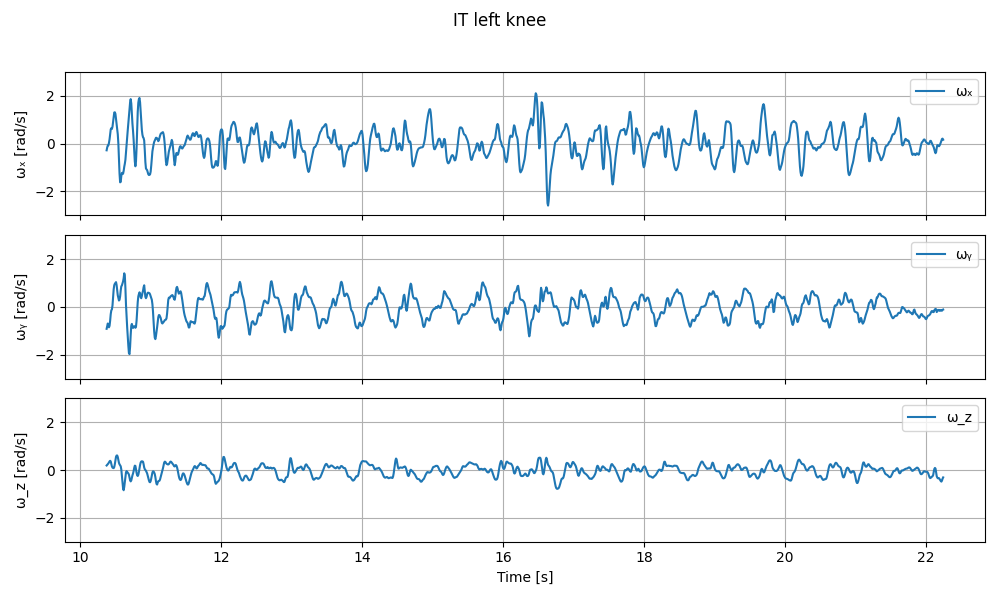

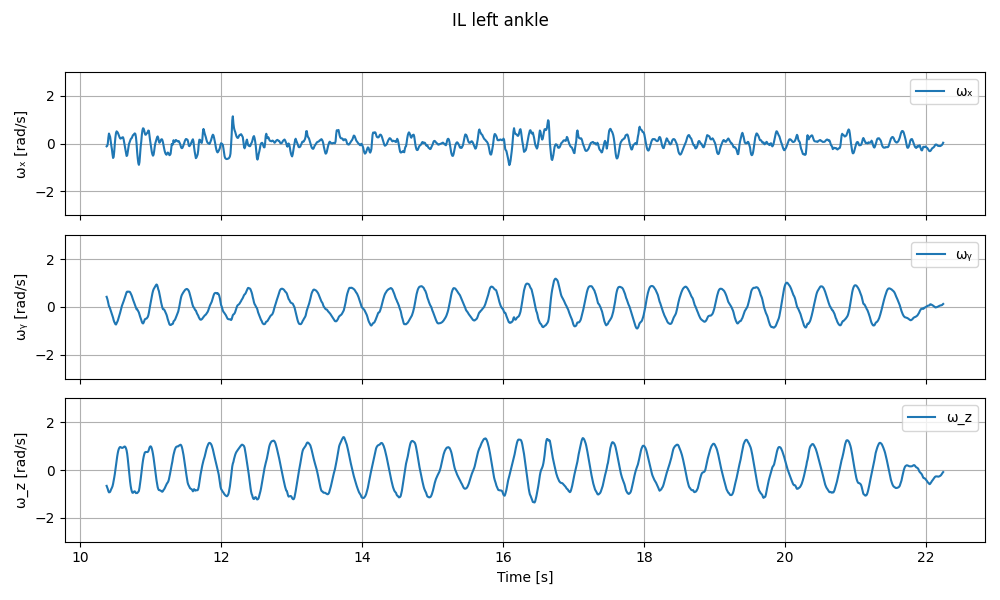

In [119]:

def plot_angular_velocity_subplots(time, omega, labels=None, title='Angular Velocity', sensor_name=None):
    """
    Plot angular velocity components over time in separate subplots, with y-limits [-2, 2].

    Parameters:
    - time: 1D array of timestamps
    - omega: 2D array of shape (3, N) or (N, 3), angular velocity components (x, y, z)
    - labels: Optional list of axis labels, e.g., ['ωₓ', 'ωᵧ', 'ω_z']
    - title: Title of the entire figure
    - sensor_name: Optional string for subplot titles (e.g., 'IB')
    """
    # Ensure shape is (3, N)
    if omega.shape[0] != 3 and omega.shape[1] == 3:
        omega = omega.T

    if labels is None:
        labels = ['ωₓ', 'ωᵧ', 'ω_z']

    fig, axs = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

    for i in range(3):
        axs[i].plot(time, omega[i],label=labels[i])
        axs[i].set_ylabel(f'{labels[i]} [rad/s]')
        axs[i].set_ylim([-3, 3])  # <-- Set y-axis limits
        axs[i].legend(loc='upper right')
        axs[i].grid(True)

    axs[-1].set_xlabel('Time [s]')
    fig.suptitle(f'{title} - {sensor_name}' if sensor_name else title)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


OR_omega = np.vstack((OR_wx[active_slice],OR_wy[active_slice],OR_wz[active_slice]))  # Shape: (3, N)
IB_omega = np.vstack((IB_wx[active_slice],IB_wy[active_slice],IB_wz[active_slice]))  # Shape: (3, N)
IT_omega = np.vstack((IT_wx[active_slice],IT_wy[active_slice],IT_wz[active_slice]))  # Shape: (3, N)
IL_omega = np.vstack((IL_wx[active_slice],IL_wy[active_slice],IL_wz[active_slice]))  # Shape: (3, N)


plot_angular_velocity_subplots(time[active_slice], OR_omega, labels=None, title='OR hoop', sensor_name=None)
plot_angular_velocity_subplots(time[active_slice], IB_omega, labels=None, title='IB left waist', sensor_name=None)
plot_angular_velocity_subplots(time[active_slice], IT_omega, labels=None, title='IT left knee', sensor_name=None)
plot_angular_velocity_subplots(time[active_slice], IL_omega, labels=None, title='IL left ankle', sensor_name=None)


# Acceleration

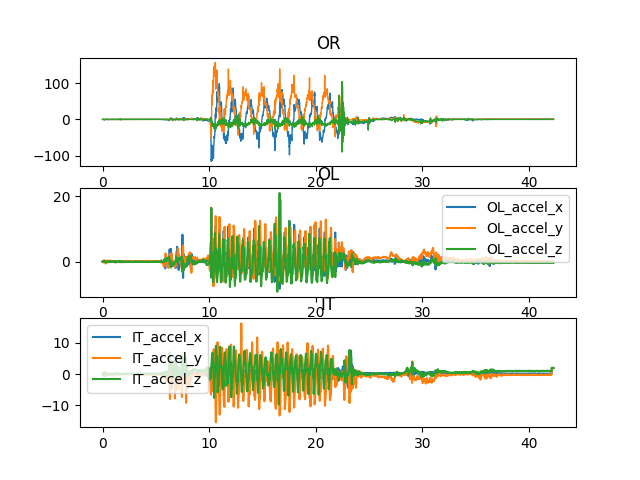

In [32]:
# Plotting raw acceleration data
%matplotlib widget

# ra: raw accelerations
fig_ra, ax_ra = plt.subplots(3)  # Creates a 3x1 grid of Axes

ax_ra[0].set_title('OR')
ax_ra[0].plot(time, OR_accel_x, label='OR_accel_x', linewidth=1)
ax_ra[0].plot(time, OR_accel_y, label='OR_accel_y', linewidth=1)
ax_ra[0].plot(time, OR_accel_z, label='OR_accel_z', linewidth=1)
# OR_accel_xy = np.sqrt(OR_accel_x**2+OR_accel_y**2)
# ax_ra[0].plot(time, OR_accel_xy, label='OR_accel_xy', linewidth=1)
# ax_ra[0].legend()

ax_ra[1].set_title('OL')
ax_ra[1].plot(time, OL_accel_x, label='OL_accel_x')
ax_ra[1].plot(time, OL_accel_y, label='OL_accel_y')
ax_ra[1].plot(time, OL_accel_z, label='OL_accel_z')
# OL_accel_xy = np.sqrt(OL_accel_x**2+OL_accel_y**2)
# ax_ra[1].plot(time, OL_accel_xy, label='OL_accel_xy')
ax_ra[1].legend()

ax_ra[2].set_title('IT')
ax_ra[2].plot(time, IT_accel_x, label='IT_accel_x')
ax_ra[2].plot(time, IT_accel_y, label='IT_accel_y')
ax_ra[2].plot(time, IT_accel_z, label='IT_accel_z')
# IT_accel_xy = np.sqrt(IT_accel_x**2+IT_accel_y**2)
# ax_ra[2].plot(time, IT_accel_xy, label='IT_accel_xy')
ax_ra[2].legend()

OR and OL accelerations period. accel_x and accel_z have same frequency. accel_y has double the frequency.

[be careful! how is the sensor oriented?] At the minimum value of az, that's the point when the sensor is being pushed up. Both sensors should read the same signal, but shifted. The shift can be adjusted by aligning the local minimza of az.

## Determining acceleration components in fixed basis & integrating to find displacement

In [33]:
# Fixed basis
E1 = np.array([1,0,0])
E2 = np.array([0,1,0])
E3 = np.array([0,0,1])

def get_fixed_frame_acceleration(ax, ay, az, psi,theta,phi):

    n = np.size(psi)

    e1p = np.zeros((3,n))
    e2p = np.zeros((3,n))
    e3p = np.zeros((3,n))

    e1pp = np.zeros((3,n))
    e2pp = np.zeros((3,n))
    e3pp = np.zeros((3,n))

    e1 = np.zeros((3,n))
    e2 = np.zeros((3,n))
    e3 = np.zeros((3,n))

    a = np.zeros((3,n))

    for i in range(n):
        # First rotation by an angle psi about E3
        e1p[:,i] = np.cos(psi[i])*E1+np.sin(psi[i])*E2
        e2p[:,i] = -np.sin(psi[i])*E1+np.cos(psi[i])*E2
        e3p[:,i] = E3
        # Second rotation by an angle theta about e2p
        e1pp[:,i] = np.cos(theta[i])*e1p[:,i]-np.sin(theta[i])*e3p[:,i]
        e2pp[:,i] = e2p[:,i]
        e3pp[:,i] = np.sin(theta[i])*e1p[:,i]+np.cos(theta[i])*e3p[:,i]
        # Third rotation by an angle phi about e1pp
        e1[:,i] = e1pp[:,i]
        e2[:,i] = np.cos(phi[i])*e2pp[:,i]+np.sin(phi[i])*e3pp[:,i]
        e3[:,i] = -np.sin(phi[i])*e2pp[:,i]+np.cos(phi[i])*e3pp[:,i]
        # acceleration in fixed frame
        a[:,i] = ax[i]*e1[:,i]+ay[i]*e2[:,i]+az[i]*e3[:,i]
    # a = A1*E1+A2*E2+A3*E3
    Ax = a[0,:]
    Ay = a[1,:]
    Az = a[2,:]

    return Ax, Ay, Az

OR_Ax, OR_Ay, OR_Az = get_fixed_frame_acceleration(OR_accel_x, OR_accel_y, OR_accel_z, OR_psi, OR_theta, OR_phi)
OL_Ax, OL_Ay, OL_Az = get_fixed_frame_acceleration(OL_accel_x, OL_accel_y, OL_accel_z, OL_psi, OL_theta, OL_phi)
IT_Ax, IT_Ay, IT_Az = get_fixed_frame_acceleration(IT_accel_x, IT_accel_y, IT_accel_z, IT_psi, IT_theta, IT_phi)
IL_Ax, IL_Ay, IL_Az = get_fixed_frame_acceleration(IL_accel_x, IL_accel_y, IL_accel_z, IL_psi, IL_theta, IL_phi)
IB_Ax, IB_Ay, IB_Az = get_fixed_frame_acceleration(IB_accel_x, IB_accel_y, IB_accel_z, IB_psi, IB_theta, IB_phi)


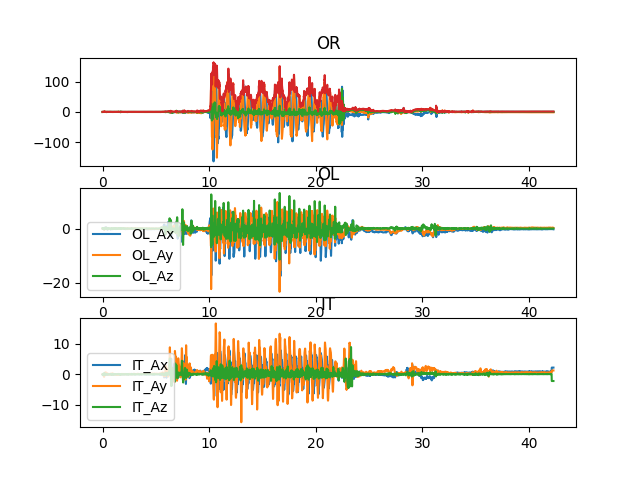

In [34]:
# Plotting raw acceleration data in fixed basis
%matplotlib widget

# ra: raw acceleriations
fig_ra, ax_ra = plt.subplots(3)  # Creates a 3x1 grid of Axes

ax_ra[0].set_title('OR')
ax_ra[0].plot(time, OR_Ax, label='OR_Ax')
ax_ra[0].plot(time, OR_Ay, label='OR_Ay')
ax_ra[0].plot(time, OR_Az, label='OR_Az')
OR_accel_xy = np.sqrt(OR_accel_x**2+OR_accel_y**2)
ax_ra[0].plot(time, OR_accel_xy, label='OR_accel_xy')
# ax_ra[0].legend()

ax_ra[1].set_title('OL')
ax_ra[1].plot(time, OL_Ax, label='OL_Ax')
ax_ra[1].plot(time, OL_Ay, label='OL_Ay')
ax_ra[1].plot(time, OL_Az, label='OL_Az')
# OL_Axy = np.sqrt(OL_Ax**2+OL_Ay**2)
# ax_ra[1].plot(time, OL_Axy, label='OL_Axy')
ax_ra[1].legend()

ax_ra[2].set_title('IT')
ax_ra[2].plot(time, IT_Ax, label='IT_Ax')
ax_ra[2].plot(time, IT_Ay, label='IT_Ay')
ax_ra[2].plot(time, IT_Az, label='IT_Az')
# IT_Axy = np.sqrt(IT_Ax**2+IT_Ay**2)
# ax_ra[2].plot(time, IT_Axy, label='IT_Axy')
ax_ra[2].legend()

We are detrending the results everytime we integrate. Explain why. Any effect on results?

In [35]:
OR_dx, OR_dy, OR_dz, OR_vx, OR_vy, OR_vz = get_position(time,OR_Ax, OR_Ay, OR_Az)
OL_dx, OL_dy, OL_dz, OL_vx, OL_vy, OL_vz = get_position(time,OL_Ax, OL_Ay, OL_Az)
IT_dx, IT_dy, IT_dz, IT_vx, IT_vy, IT_vz = get_position(time,IT_Ax, IT_Ay, IT_Az)
IL_dx, IL_dy, IL_dz, IL_vx, IL_vy, IL_vz = get_position(time,IL_Ax, IL_Ay, IL_Az)
IB_dx, IB_dy, IB_dz, IB_vx, IB_vy, IB_vz = get_position(time,IB_Ax, IB_Ay, IB_Az)

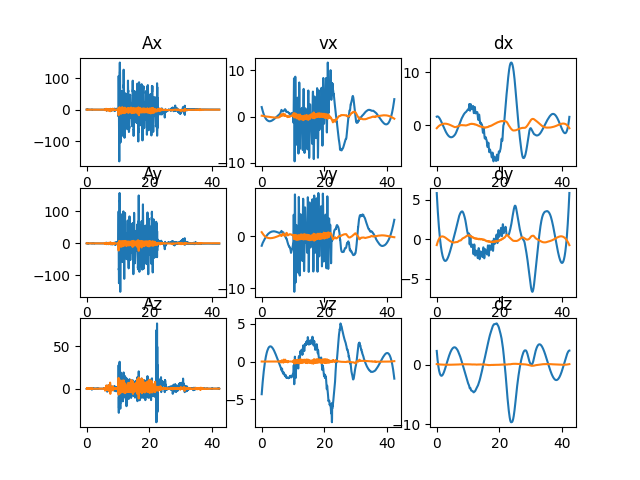

In [36]:
# Plot positions of two points on hoop
%matplotlib widget

fig, ax = plt.subplots(3, 3)  # Creates a 3x1 grid of Axes

# acceleration subplots
ax[0, 0].set_title('Ax')
ax[0, 0].plot(time, OR_Ax, label='OR_Ax')#, color='blue')
ax[0, 0].plot(time, OL_Ax, label='OL_Ax')#, color='orange')
# ax[0, 0].legend()

ax[1, 0].set_title('Ay')
ax[1, 0].plot(time, OR_Ay)
ax[1, 0].plot(time, OL_Ay)

ax[2, 0].set_title('Az')
ax[2, 0].plot(time, OR_Az)
ax[2, 0].plot(time, OL_Az)

# velocity subplots
ax[0, 1].set_title('vx')
ax[0, 1].plot(time[1:], OR_vx)
ax[0, 1].plot(time[1:], OL_vx)

ax[1, 1].set_title('vy')
ax[1, 1].plot(time[1:], OR_vy)
ax[1, 1].plot(time[1:], OL_vy)

ax[2, 1].set_title('vz')
ax[2, 1].plot(time[1:], OR_vz)
ax[2, 1].plot(time[1:], OL_vz)

# displacement subplots
ax[0, 2].set_title('dx')
ax[0, 2].plot(time[2:], OR_dx)
ax[0, 2].plot(time[2:], OL_dx)

ax[1, 2].set_title('dy')
ax[1, 2].plot(time[2:], OR_dy)
ax[1, 2].plot(time[2:], OL_dy)

ax[2, 2].set_title('dz')
ax[2, 2].plot(time[2:], OR_dz)
ax[2, 2].plot(time[2:], OL_dz)

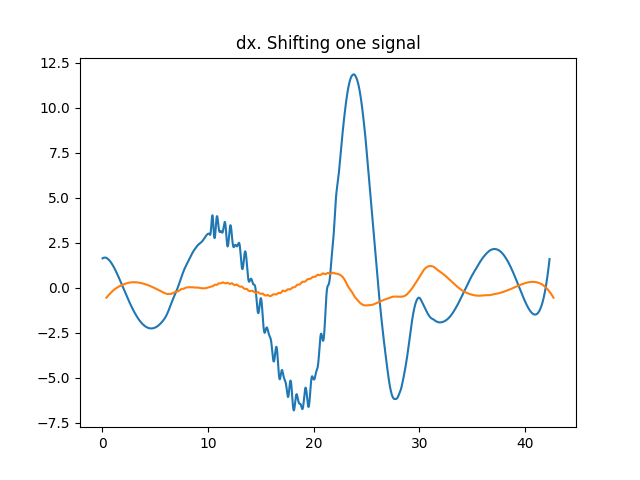

In [37]:
# Trying to align the two signals
%matplotlib widget

fig, ax = plt.subplots()  # Creates a 3x1 grid of Axes

ax.set_title('dx. Shifting one signal')
# ax.plot(time[2:], OR_dx,'.')
ax.plot(time[2:], OR_dx)
ax.plot(time[2:]+0.37, OL_dx)
# ax.plot(time[2:]+0.37,OL_dx,'.')


Text(0.5, 0.92, 'Hoop Sensor Displacement')

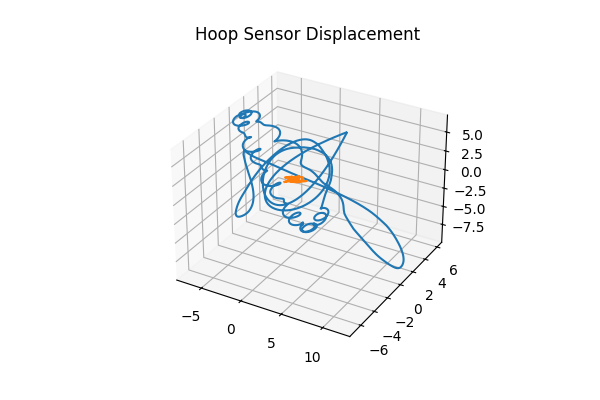

In [38]:
# 3D plot of hoop sensor displacement path
%matplotlib widget
fig_hooppath = plt.figure(figsize=(6,4))
ax = fig_hooppath.add_subplot(projection='3d')
ax.plot(OR_dx,OR_dy,OR_dz)
ax.plot(OL_dx,OL_dy,OL_dz)
ax.set_title('Hoop Sensor Displacement')

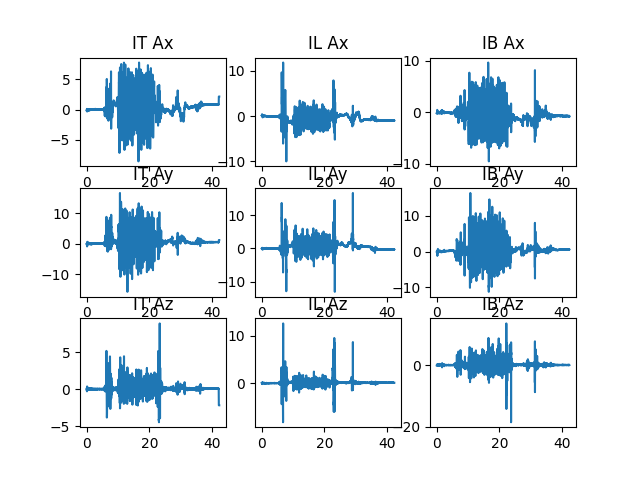

In [39]:
# Plot positions of hips
%matplotlib widget
fig_ahip, ax_ahip = plt.subplots(3, 3)  # Creates a 3x1 grid of Axes

# IT
ax_ahip[0, 0].set_title('IT Ax')
ax_ahip[0, 0].plot(time, IT_Ax)

ax_ahip[1, 0].set_title('IT Ay')
ax_ahip[1, 0].plot(time, IT_Ay)

ax_ahip[2, 0].set_title('IT Az')
ax_ahip[2, 0].plot(time, IT_Az)

# IL
ax_ahip[0, 1].set_title('IL Ax')
ax_ahip[0, 1].plot(time, IL_Ax)

ax_ahip[1, 1].set_title('IL Ay')
ax_ahip[1, 1].plot(time, IL_Ay)

ax_ahip[2, 1].set_title('IL Az')
ax_ahip[2, 1].plot(time, IL_Az)

# IB
ax_ahip[0, 2].set_title('IB Ax')
ax_ahip[0, 2].plot(time, IB_Ax)

ax_ahip[1, 2].set_title('IB Ay')
ax_ahip[1, 2].plot(time, IB_Ay)

ax_ahip[2, 2].set_title('IB Az')
ax_ahip[2, 2].plot(time, IB_Az)



One side of hip moves more (has more agressive bursts) than the other side. Verified by video?
Also for lower hip, most motion along Ay. See orientation of sensor to interpret.

# Hip displacement

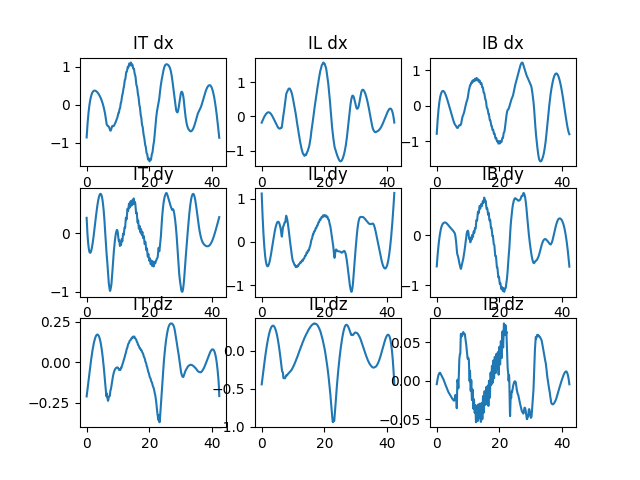

In [40]:
# Plot positions of hips
%matplotlib widget
fig_xhip, ax_xhip = plt.subplots(3, 3)  # Creates a 3x1 grid of Axes

# IT
ax_xhip[0, 0].set_title('IT dx')
ax_xhip[0, 0].plot(time[2:], IT_dx)

ax_xhip[1, 0].set_title('IT dy')
ax_xhip[1, 0].plot(time[2:], IT_dy)

ax_xhip[2, 0].set_title('IT dz')
ax_xhip[2, 0].plot(time[2:], IT_dz)

# IL
ax_xhip[0, 1].set_title('IL dx')
ax_xhip[0, 1].plot(time[2:], IL_dx)

ax_xhip[1, 1].set_title('IL dy')
ax_xhip[1, 1].plot(time[2:], IL_dy)

ax_xhip[2, 1].set_title('IL dz')
ax_xhip[2, 1].plot(time[2:], IL_dz)

# IB
ax_xhip[0, 2].set_title('IB dx')
ax_xhip[0, 2].plot(time[2:], IB_dx)

ax_xhip[1, 2].set_title('IB dy')
ax_xhip[1, 2].plot(time[2:], IB_dy)

ax_xhip[2, 2].set_title('IB dz')
ax_xhip[2, 2].plot(time[2:], IB_dz)



So interesting the jitters along dz for the upper hip and in all directions for lower hip. Maybe upper hip dz are needed to sustain hoop and lower hip jitters enables the upper hip to create these jitters. No jitters in upper hip in the horizontal plane. Look at human body anatomy to verify this.

Text(0.5, 0.92, 'Waist Sensor Displacement')

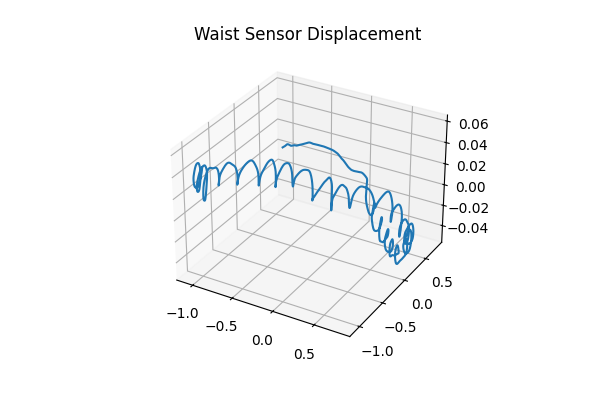

In [120]:
# 3D plot of hip sensor displacement path
%matplotlib widget
fig_hippath = plt.figure(figsize=(6,4))
ax = fig_hippath.add_subplot(projection='3d')
ax.plot(IB_dx[1000:2500],IB_dy[1000:2500],IB_dz[1000:2500])
ax.set_title('Waist Sensor Displacement')

Is it possible that the hip is displacing 20 cm along the vertical. Or is this vertical displacement an artifact of errors.

Text(0.5, 0.92, 'Hip Sensor Displacement')

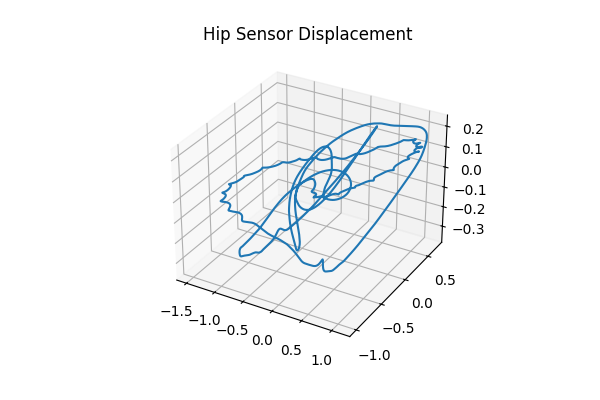

In [42]:
# 3D plot of hip sensor displacement path
%matplotlib widget
fig_hippath = plt.figure(figsize=(6,4))
ax = fig_hippath.add_subplot(projection='3d')
ax.plot(IT_dx,IT_dy,IT_dz)
ax.set_title('Hip Sensor Displacement')

## here need to add initial sensor locations

/var/folders/lg/7kf9vln158j8p2tsj0l79gt00000gp/T/ipykernel_38846/3267788272.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig_paths = plt.figure(figsize=(6,4))


Text(0.5, 0.92, 'All Sensor Displacement Paths')

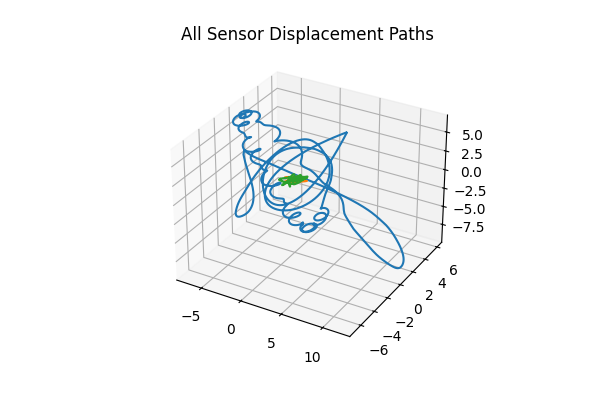

In [43]:
# On same plot
%matplotlib widget
# %matplotlib notebook


# 3D plot of all sensor displacement paths

fig_paths = plt.figure(figsize=(6,4))
ax = fig_paths.add_subplot(projection='3d')
ax.plot(OR_dx,OR_dy,OR_dz, label='OR_sensor')
ax.plot(OL_dx,OL_dy,OL_dz, label='OL_sensor')
ax.plot(IT_dx,IT_dy,IT_dz, label='IT_sensor')
ax.set_title('All Sensor Displacement Paths')


# Animating hoop motion

In [44]:
# # Animation of sensor location in time
# %matplotlib widget
# # Set up figure and 3D axes
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.view_init(elev=20, azim=35)
# ax.set_box_aspect([4, 4, 3])  # Adjust for box on

# # Fixed basis vectors
# ax.quiver(0, 0, 0, 0.01, 0, 0, linewidth=2, color='k')
# ax.quiver(0, 0, 0, 0, 0.01, 0, linewidth=2, color='k')
# ax.quiver(0, 0, 0, 0, 0, 0.01, linewidth=2, color='k')

# ntime = np.size(OR_dx)

# # Prepare video writer
# writer = FFMpegWriter(fps=round(1/dt)//3)
# with writer.saving(fig, "sensor_locations.mp4", dpi=200):

#     max_range = 1
#     ax.set_xlim([-max_range, max_range])
#     ax.set_ylim([-max_range, max_range])
#     ax.set_zlim([-max_range, max_range])

#     for i in range(2,ntime):

#         ax.set_title(f"All Sensor Displacement Paths. i = {i}")

#         marker_OR, = ax.plot(OR_dx[i], OR_dy[i], OR_dz[i],
#                           marker='*', color='r', linewidth=2)
#         marker_OL, = ax.plot(OL_dx[i], OL_dy[i], OL_dz[i],
#                           marker='*', color='g', linewidth=2)
#         marker_IT, = ax.plot(IT_dx[i], IT_dy[i], IT_dz[i],
#                           marker='*', color='b', linewidth=2)

#         plt.pause(0.001)
#         writer.grab_frame()

#         # Remove current frame's artists
#         for artist in [marker_OR, marker_OL, marker_IT]:
#             artist.remove()

In [45]:
# # Plotting hoop seperately from two sensor data on same plot
# # %matplotlib widget

# colors = ['k','b','r','g']
# r_arr = [r,r,0.12,0.12]

# # Set up figure and 3D axes
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.view_init(elev=20, azim=35)
# ax.set_box_aspect([4, 4, 3])  # Adjust for box on

# max_range = 1
# ax.set_xlim([-max_range, max_range])
# ax.set_ylim([-max_range, max_range])
# ax.set_zlim([-max_range, max_range])

# # Fixed basis vectors
# ax.quiver(0, 0, 0, 0.01, 0, 0, linewidth=2, color='k')
# ax.quiver(0, 0, 0, 0, 0.01, 0, linewidth=2, color='k')
# ax.quiver(0, 0, 0, 0, 0, 0.01, linewidth=2, color='k')

# delta = np.linspace(0, 2 * np.pi, 100)
# xC = np.zeros(3)  # center of hoop

# psi = np.vstack((OL_psi,OR_psi,IT_psi,IL_psi)) 
# theta = np.vstack((OL_theta,OR_theta,IT_theta,IL_theta)) 
# phi = np.vstack((OL_phi,OR_phi,IT_phi,IL_phi)) 

# wx = np.vstack((OL_wx, OR_wx,IT_wx,IL_wx)) 
# wy = np.vstack((OL_wy, OR_wy,IT_wy,IL_wy)) 
# wz = np.vstack((OL_wz, OR_wz,IT_wz,IL_wz)) 

# OR_dx_padded = np.concatenate(([0, 0], OR_dx))
# OR_dy_padded = np.concatenate(([0, 0], OR_dy))
# OR_dz_padded = np.concatenate(([0, 0], OR_dz))
        
# OR_vx_padded = np.concatenate(([0], OR_vx))
# OR_vy_padded = np.concatenate(([0], OR_vy))
# OR_vz_padded = np.concatenate(([0], OR_vz))

# OL_dx_padded = np.concatenate(([0, 0], OL_dx))
# OL_dy_padded = np.concatenate(([0, 0], OL_dy))
# OL_dz_padded = np.concatenate(([0, 0], OL_dz))
        
# OL_vx_padded = np.concatenate(([0], OL_vx))
# OL_vy_padded = np.concatenate(([0], OL_vy))
# OL_vz_padded = np.concatenate(([0], OL_vz))

# IT_dx_padded = np.concatenate(([0, 0], IT_dx))
# IT_dy_padded = np.concatenate(([0, 0], IT_dy))
# IT_dz_padded = np.concatenate(([0, 0], IT_dz))
        
# IT_vx_padded = np.concatenate(([0], IT_vx))
# IT_vy_padded = np.concatenate(([0], IT_vy))
# IT_vz_padded = np.concatenate(([0], IT_vz))

# IB_dx_padded = np.concatenate(([0, 0], IB_dx))
# IB_dy_padded = np.concatenate(([0, 0], IB_dy))
# IB_dz_padded = np.concatenate(([0, 0], IB_dz))
        
# IB_vx_padded = np.concatenate(([0], IB_vx))
# IB_vy_padded = np.concatenate(([0], IB_vy))
# IB_vz_padded = np.concatenate(([0], IB_vz))

# dx = np.vstack((OL_dx_padded, OR_dx_padded, IT_dx_padded, IB_dx_padded)) 
# dy = np.vstack((OL_dy_padded, OR_dy_padded, IT_dy_padded, IB_dy_padded)) 
# dz = np.vstack((OL_dz_padded, OR_dz_padded, IT_dz_padded, IB_dz_padded)) 

# vx = np.vstack((OL_vx_padded, OR_vx_padded, IT_vx_padded, IB_vx_padded)) 
# vy = np.vstack((OL_vy_padded, OR_vy_padded, IT_vy_padded, IB_vy_padded)) 
# vz = np.vstack((OL_vz_padded, OR_vz_padded, IT_vz_padded, IB_vz_padded))

# nsensor = np.shape(psi)[0]
# ntime = np.shape(psi)[1]

# KE_hoop = np.zeros((nsensor,ntime))
# PE_hoop = np.zeros((nsensor,ntime))

# exp = np.zeros((3,nsensor,ntime))
# eyp = np.zeros((3,nsensor,ntime))
# ezp = np.zeros((3,nsensor,ntime))

# expp = np.zeros((3,nsensor,ntime))
# eypp = np.zeros((3,nsensor,ntime))
# ezpp = np.zeros((3,nsensor,ntime))

# ex = np.zeros((3,nsensor,ntime))
# ey = np.zeros((3,nsensor,ntime))
# ez = np.zeros((3,nsensor,ntime))

# omega_hoop = np.zeros((3,nsensor,ntime))
# vC = np.zeros((3,nsensor,ntime))

# mark = [None] * nsensor
# hoop = [None] * nsensor

# # Prepare video writer
# writer = FFMpegWriter(fps=round(1/dt)//3)
# with writer.saving(fig, "out/hula_hoop_two_sensors.mp4", dpi=200):

#     for t in range(ntime):

#         for s in range(nsensor):
#             # s == 0, sensor OL
#             # s == 1, sensor OR

#             # First rotation by an angle psi about E3
#             exp[:,s,t] = np.cos(psi[s,t])*E1+np.sin(psi[s,t])*E2
#             eyp[:,s,t] = -np.sin(psi[s,t])*E1+np.cos(psi[s,t])*E2
#             ezp[:,s,t] = E3
#             # Second rotation by an angle theta about e2p
#             expp[:,s,t] = np.cos(theta[s,t])*exp[:,s,t]-np.sin(theta[s,t])*ezp[:,s,t]
#             eypp[:,s,t] = eyp[:,s,t]
#             ezpp[:,s,t] = np.sin(theta[s,t])*exp[:,s,t]+np.cos(theta[s,t])*ezp[:,s,t]
#             # Third rotation by an angle phi about e1pp
#             ex[:,s,t] = expp[:,s,t]
#             ey[:,s,t] = np.cos(phi[s,t])*eypp[:,s,t]+np.sin(phi[s,t])*ezpp[:,s,t]
#             ez[:,s,t] = -np.sin(phi[s,t])*eypp[:,s,t]+np.cos(phi[s,t])*ezpp[:,s,t]

#             omega_hoop[:,s,t] = wx[s,t]*ex[:,s,t]+wy[s,t]*ey[:,s,t]+wz[s,t]*ez[:,s,t]

#             vC[:,s,t] = np.array([vx[s,t],vy[s,t],vz[s,t]])+np.cross(omega_hoop[:,s,t],r_arr[s]*ey[:,s,t])

#             KE_hoop[s,t] = 0.5*(Ixx*wx[s,t]**2+Iyy*wy[s,t]**2+Izz*wz[s,t]**2)+0.5*nsensor*np.linalg.norm(vC[:,s,t])**2
#             PE_hoop[s,t] = m*g*dz[s,t]

#             ax.set_title(f"sensor = {s}, t = {t}, ψ = {psi[s,t]:.2f}, θ = {theta[s,t]:.2f}, φ = {phi[s,t]:.2f}")

#             # Blue vectors
#             e1p_plot = ax.quiver(0, 0, 0, *0.01*exp[:,s,t], linewidth=1, color='b')
#             e2p_plot = ax.quiver(0, 0, 0, *0.01*eyp[:,s,t], linewidth=1, color='b')
#             e3p_plot = ax.quiver(0, 0, 0, *0.01*ezp[:,s,t], linewidth=1, color='b')
            
#             # Red vectors
#             e1pp_plot = ax.quiver(0, 0, 0, *0.01*expp[:,s,t], linewidth=1, color='r')
#             e2pp_plot = ax.quiver(0, 0, 0, *0.01*eypp[:,s,t], linewidth=1, color='r')
#             e3pp_plot = ax.quiver(0, 0, 0, *0.01*ezpp[:,s,t], linewidth=1, color='r')

#             # Green vectors
#             e1_plot = ax.quiver(0, 0, 0, *0.01*ex[:,s,t], linewidth=1, color='g')
#             e2_plot = ax.quiver(0, 0, 0, *0.01*ey[:,s,t], linewidth=1, color='g')
#             e3_plot = ax.quiver(0, 0, 0, *0.01*ez[:,s,t], linewidth=1, color='g')

#             OR_0 = np.array([0,0,0])
#             OL_0 = OR_0+r_arr[s]*(ey[:,1,0]-ey[:,0,0])
#             IT_0 = OR_0
#             IL_0 = IT_0-2*r_arr[s]*ez[:,0,0]

#             if s == 0:  # OL
#                 xC = OL_0+np.array([dx[s,t],dy[s,t],dz[s,t]])+r_arr[s]*ey[:,s,t]
#             if s == 1:  # OR
#                 xC = OR_0+np.array([dx[s,t],dy[s,t],dz[s,t]])+r_arr[s]*ey[:,s,t]
#             if s == 2:  # IT
#                 xC = IT_0+np.array([dx[s,t],dy[s,t],dz[s,t]])-r_arr[s]*ez[:,s,t]
#             if s == 3:  # IL
#                 xC = IL_0+np.array([dx[s,t],dy[s,t],dz[s,t]])-r_arr[s]*ez[:,s,t]

            
#             # Circle
#             xCircle = np.zeros((100, 3))
#             if s == 0 or s == 1:
#                 for j in range(100):
#                     xCircle[j, :] = xC + r_arr[s] * (np.cos(delta[j]) * ex[:,s,t] + np.sin(delta[j]) * ey[:,s,t])
#             if s == 2 or s == 3:
#                 for j in range(100):
#                     xCircle[j, :] = xC + r_arr[s] * (np.cos(delta[j]) * ey[:,s,t] + np.sin(delta[j]) * ez[:,s,t])

#             mark[s], = ax.plot([xCircle[0, 0]], [xCircle[0, 1]], [xCircle[0, 2]],
#                             marker='*', color='r', linewidth=2)
#             hoop[s], = ax.plot(xCircle[:, 0], xCircle[:, 1], xCircle[:, 2],
#                             '.', color=colors[s], linewidth=2)

#         # plt.pause(0.001)
#         writer.grab_frame()

#         # Remove current frame's artists
#         for s in range(nsensor):
#             mark[s].remove()
#             hoop[s].remove()
#         for artist in [e1p_plot, e2p_plot, e3p_plot,
#                     e1pp_plot, e2pp_plot, e3pp_plot,
#                     e1_plot, e2_plot, e3_plot]:
#             artist.remove()

# # total energy of hoop
# E_hoop = KE_hoop+PE_hoop


In [46]:
# Plotting hoop seperately from two sensor data on same plot
# %matplotlib widget

colors = ['k','b','r','g']
r_arr = [r,r,0.12,0.12]

# # Set up figure and 3D axes
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.view_init(elev=20, azim=35)
# ax.set_box_aspect([4, 4, 3])  # Adjust for box on

# max_range = 1
# ax.set_xlim([-max_range, max_range])
# ax.set_ylim([-max_range, max_range])
# ax.set_zlim([-max_range, max_range])

# # Fixed basis vectors
# ax.quiver(0, 0, 0, 0.01, 0, 0, linewidth=2, color='k')
# ax.quiver(0, 0, 0, 0, 0.01, 0, linewidth=2, color='k')
# ax.quiver(0, 0, 0, 0, 0, 0.01, linewidth=2, color='k')

delta = np.linspace(0, 2 * np.pi, 100)
xC = np.zeros(3)  # center of hoop

psi = np.vstack((OL_psi,OR_psi,IT_psi,IL_psi)) 
theta = np.vstack((OL_theta,OR_theta,IT_theta,IL_theta)) 
phi = np.vstack((OL_phi,OR_phi,IT_phi,IL_phi)) 

wx = np.vstack((OL_wx, OR_wx,IT_wx,IL_wx)) 
wy = np.vstack((OL_wy, OR_wy,IT_wy,IL_wy)) 
wz = np.vstack((OL_wz, OR_wz,IT_wz,IL_wz)) 

OR_dx_padded = np.concatenate(([0, 0], OR_dx))
OR_dy_padded = np.concatenate(([0, 0], OR_dy))
OR_dz_padded = np.concatenate(([0, 0], OR_dz))
        
OR_vx_padded = np.concatenate(([0], OR_vx))
OR_vy_padded = np.concatenate(([0], OR_vy))
OR_vz_padded = np.concatenate(([0], OR_vz))

OL_dx_padded = np.concatenate(([0, 0], OL_dx))
OL_dy_padded = np.concatenate(([0, 0], OL_dy))
OL_dz_padded = np.concatenate(([0, 0], OL_dz))
        
OL_vx_padded = np.concatenate(([0], OL_vx))
OL_vy_padded = np.concatenate(([0], OL_vy))
OL_vz_padded = np.concatenate(([0], OL_vz))

IT_dx_padded = np.concatenate(([0, 0], IT_dx))
IT_dy_padded = np.concatenate(([0, 0], IT_dy))
IT_dz_padded = np.concatenate(([0, 0], IT_dz))
        
IT_vx_padded = np.concatenate(([0], IT_vx))
IT_vy_padded = np.concatenate(([0], IT_vy))
IT_vz_padded = np.concatenate(([0], IT_vz))

IB_dx_padded = np.concatenate(([0, 0], IB_dx))
IB_dy_padded = np.concatenate(([0, 0], IB_dy))
IB_dz_padded = np.concatenate(([0, 0], IB_dz))
        
IB_vx_padded = np.concatenate(([0], IB_vx))
IB_vy_padded = np.concatenate(([0], IB_vy))
IB_vz_padded = np.concatenate(([0], IB_vz))

dx = np.vstack((OL_dx_padded, OR_dx_padded, IT_dx_padded, IB_dx_padded)) 
dy = np.vstack((OL_dy_padded, OR_dy_padded, IT_dy_padded, IB_dy_padded)) 
dz = np.vstack((OL_dz_padded, OR_dz_padded, IT_dz_padded, IB_dz_padded)) 

vx = np.vstack((OL_vx_padded, OR_vx_padded, IT_vx_padded, IB_vx_padded)) 
vy = np.vstack((OL_vy_padded, OR_vy_padded, IT_vy_padded, IB_vy_padded)) 
vz = np.vstack((OL_vz_padded, OR_vz_padded, IT_vz_padded, IB_vz_padded))

nsensor = np.shape(psi)[0]
ntime = np.shape(psi)[1]

KE_hoop = np.zeros((nsensor,ntime))
PE_hoop = np.zeros((nsensor,ntime))

exp = np.zeros((3,nsensor,ntime))
eyp = np.zeros((3,nsensor,ntime))
ezp = np.zeros((3,nsensor,ntime))

expp = np.zeros((3,nsensor,ntime))
eypp = np.zeros((3,nsensor,ntime))
ezpp = np.zeros((3,nsensor,ntime))

ex = np.zeros((3,nsensor,ntime))
ey = np.zeros((3,nsensor,ntime))
ez = np.zeros((3,nsensor,ntime))

omega_hoop = np.zeros((3,nsensor,ntime))
vC = np.zeros((3,nsensor,ntime))

mark = [None] * nsensor
hoop = [None] * nsensor

# Prepare video writer
# writer = FFMpegWriter(fps=round(1/dt)//3)
# with writer.saving(fig, "out/hula_hoop_two_sensors.mp4", dpi=200):

for t in range(ntime):

    for s in range(nsensor):
        # s == 0, sensor OL
        # s == 1, sensor OR

        # First rotation by an angle psi about E3
        exp[:,s,t] = np.cos(psi[s,t])*E1+np.sin(psi[s,t])*E2
        eyp[:,s,t] = -np.sin(psi[s,t])*E1+np.cos(psi[s,t])*E2
        ezp[:,s,t] = E3
        # Second rotation by an angle theta about e2p
        expp[:,s,t] = np.cos(theta[s,t])*exp[:,s,t]-np.sin(theta[s,t])*ezp[:,s,t]
        eypp[:,s,t] = eyp[:,s,t]
        ezpp[:,s,t] = np.sin(theta[s,t])*exp[:,s,t]+np.cos(theta[s,t])*ezp[:,s,t]
        # Third rotation by an angle phi about e1pp
        ex[:,s,t] = expp[:,s,t]
        ey[:,s,t] = np.cos(phi[s,t])*eypp[:,s,t]+np.sin(phi[s,t])*ezpp[:,s,t]
        ez[:,s,t] = -np.sin(phi[s,t])*eypp[:,s,t]+np.cos(phi[s,t])*ezpp[:,s,t]

        omega_hoop[:,s,t] = wx[s,t]*ex[:,s,t]+wy[s,t]*ey[:,s,t]+wz[s,t]*ez[:,s,t]

        vC[:,s,t] = np.array([vx[s,t],vy[s,t],vz[s,t]])+np.cross(omega_hoop[:,s,t],r_arr[s]*ey[:,s,t])

        KE_hoop[s,t] = 0.5*(Ixx*wx[s,t]**2+Iyy*wy[s,t]**2+Izz*wz[s,t]**2)+0.5*nsensor*np.linalg.norm(vC[:,s,t])**2
        PE_hoop[s,t] = m*g*dz[s,t]

        # ax.set_title(f"sensor = {s}, t = {t}, ψ = {psi[s,t]:.2f}, θ = {theta[s,t]:.2f}, φ = {phi[s,t]:.2f}")

        # # Blue vectors
        # e1p_plot = ax.quiver(0, 0, 0, *0.01*exp[:,s,t], linewidth=1, color='b')
        # e2p_plot = ax.quiver(0, 0, 0, *0.01*eyp[:,s,t], linewidth=1, color='b')
        # e3p_plot = ax.quiver(0, 0, 0, *0.01*ezp[:,s,t], linewidth=1, color='b')
        
        # # Red vectors
        # e1pp_plot = ax.quiver(0, 0, 0, *0.01*expp[:,s,t], linewidth=1, color='r')
        # e2pp_plot = ax.quiver(0, 0, 0, *0.01*eypp[:,s,t], linewidth=1, color='r')
        # e3pp_plot = ax.quiver(0, 0, 0, *0.01*ezpp[:,s,t], linewidth=1, color='r')

        # # Green vectors
        # e1_plot = ax.quiver(0, 0, 0, *0.01*ex[:,s,t], linewidth=1, color='g')
        # e2_plot = ax.quiver(0, 0, 0, *0.01*ey[:,s,t], linewidth=1, color='g')
        # e3_plot = ax.quiver(0, 0, 0, *0.01*ez[:,s,t], linewidth=1, color='g')

        # OR_0 = np.array([0,0,0])
        # OL_0 = OR_0+r_arr[s]*(ey[:,1,0]-ey[:,0,0])
        # IT_0 = OR_0
        # IL_0 = IT_0-2*r_arr[s]*ez[:,0,0]

        # if s == 0:  # OL
        #     xC = OL_0+np.array([dx[s,t],dy[s,t],dz[s,t]])+r_arr[s]*ey[:,s,t]
        # if s == 1:  # OR
        #     xC = OR_0+np.array([dx[s,t],dy[s,t],dz[s,t]])+r_arr[s]*ey[:,s,t]
        # if s == 2:  # IT
        #     xC = IT_0+np.array([dx[s,t],dy[s,t],dz[s,t]])-r_arr[s]*ez[:,s,t]
        # if s == 3:  # IL
        #     xC = IL_0+np.array([dx[s,t],dy[s,t],dz[s,t]])-r_arr[s]*ez[:,s,t]

        
        # # Circle
        # xCircle = np.zeros((100, 3))
        # if s == 0 or s == 1:
        #     for j in range(100):
        #         xCircle[j, :] = xC + r_arr[s] * (np.cos(delta[j]) * ex[:,s,t] + np.sin(delta[j]) * ey[:,s,t])
        # if s == 2 or s == 3:
        #     for j in range(100):
        #         xCircle[j, :] = xC + r_arr[s] * (np.cos(delta[j]) * ey[:,s,t] + np.sin(delta[j]) * ez[:,s,t])

        # mark[s], = ax.plot([xCircle[0, 0]], [xCircle[0, 1]], [xCircle[0, 2]],
        #                 marker='*', color='r', linewidth=2)
        # hoop[s], = ax.plot(xCircle[:, 0], xCircle[:, 1], xCircle[:, 2],
        #                 '.', color=colors[s], linewidth=2)

    # # plt.pause(0.001)
    # writer.grab_frame()
    #
    # # Remove current frame's artists
    # for s in range(nsensor):
    #     mark[s].remove()
    #     hoop[s].remove()
    # for artist in [e1p_plot, e2p_plot, e3p_plot,
    #             e1pp_plot, e2pp_plot, e3pp_plot,
    #             e1_plot, e2_plot, e3_plot]:
    #     artist.remove()

# total energy of hoop
E_hoop = KE_hoop+PE_hoop


NameError: name 'r' is not defined

# Measures of Rigidity

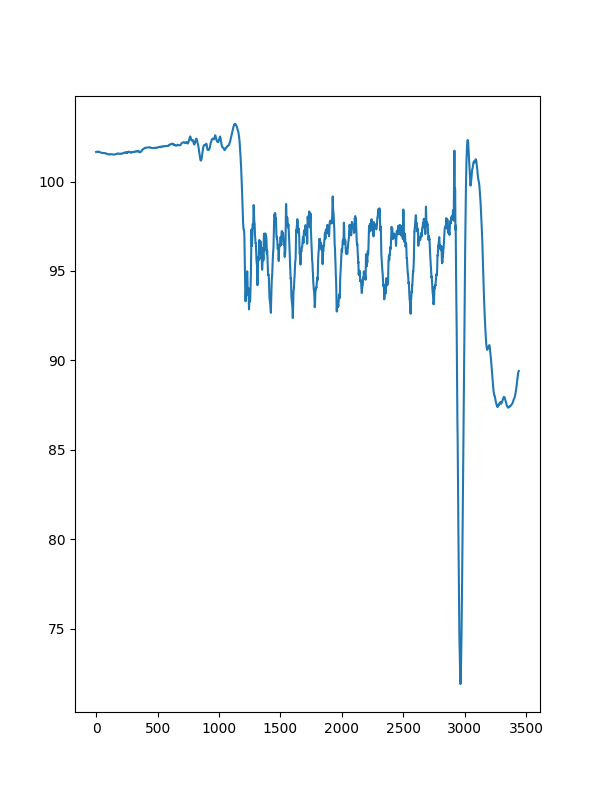

In [26]:
%matplotlib widget

ntime = np.shape(psi)[1]

angle = np.zeros(ntime)
for t in range(ntime):
    angle[t] = np.arccos(np.dot(ey[:,0,t],ey[:,1,t]))

fig_a, ax_a = plt.subplots(figsize=(6, 8))
ax_a.plot(180-angle*180/np.pi)



The angle between the two corotational ey vectors of the two sensors on the hoop should remain constant. This 40degrees angle change is too much. Is one of the sensors moving?

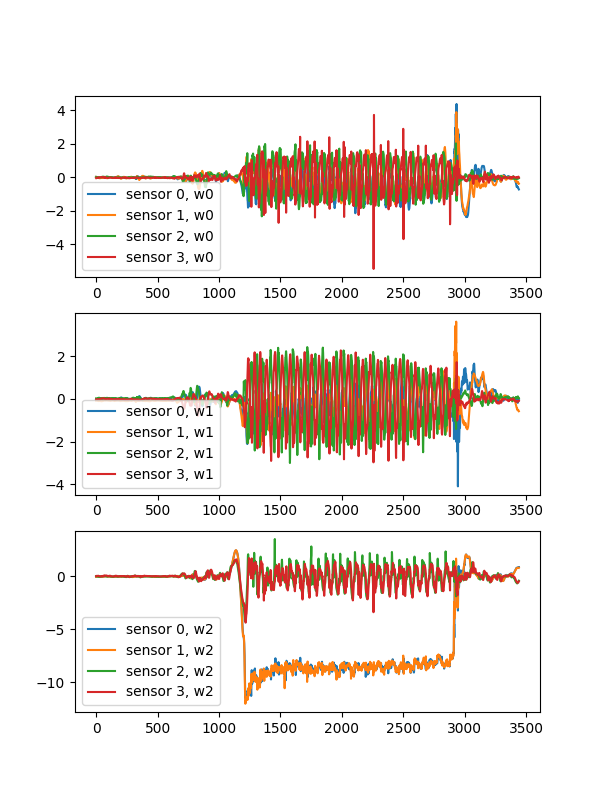

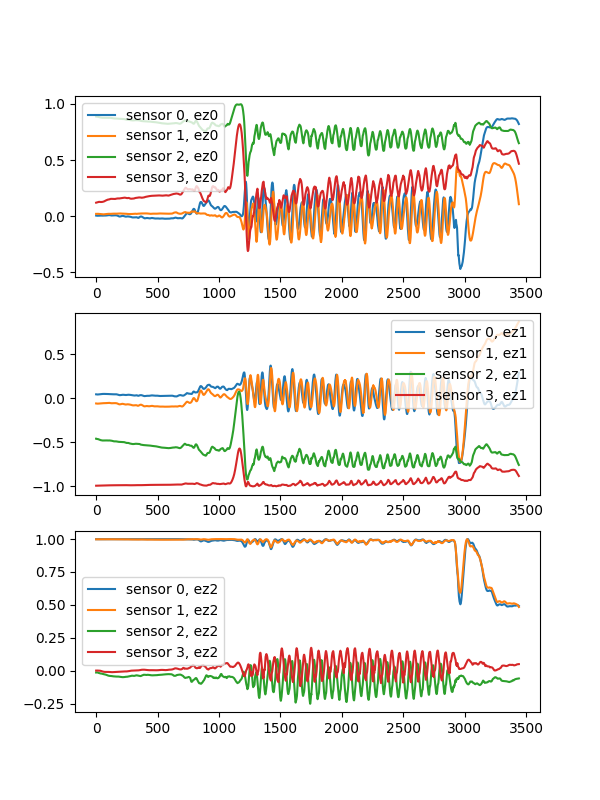

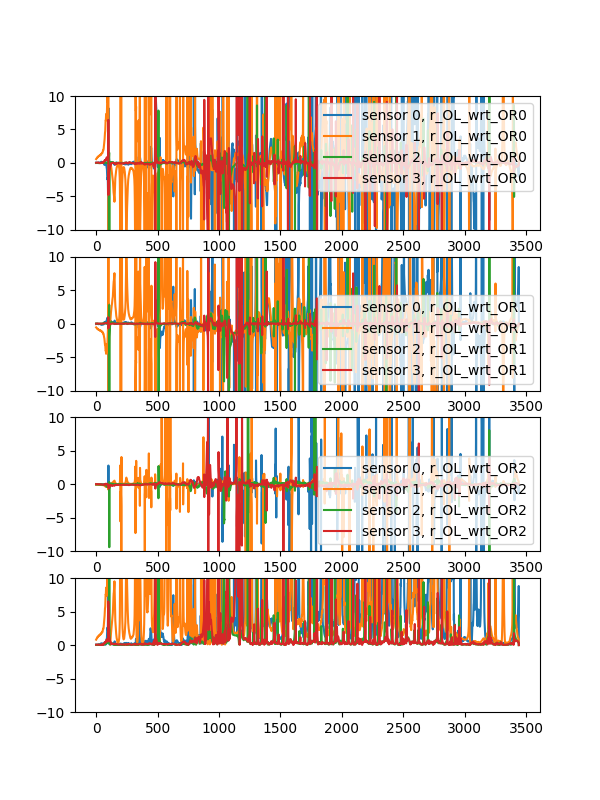

In [27]:
# Comparing data from the two sensors
# Measures of rigidity

# Angular velocities
fig_w, ax_w = plt.subplots(3,1,figsize=(6, 8))
for s in range(nsensor):
    for i in range(3):
        ax_w[i].plot(omega_hoop[i,s,:],label=f'sensor {s}, w{i}') 
        ax_w[i].legend()

# Unit vector ez
fig_ez, ax_ez = plt.subplots(3,1,figsize=(6, 8))
for s in range(nsensor):
    for i in range(3):
        ax_ez[i].plot(ez[i,s,:],label=f'sensor {s}, ez{i}') 
        ax_ez[i].legend()

# Calculating the relative position vector between the two sensors
# https://chatgpt.com/share/687ff75c-b810-8011-bd51-12152ce2bfab

fig_r, ax_r = plt.subplots(4,1,figsize=(6, 8))

r_OL_wrt_OR = np.zeros((3,nsensor,ntime))
norm_r_OL_wrt_OR = np.zeros((nsensor,ntime))

for t in range(ntime-1):
    temp1 = np.array([OL_vx[t], OL_vy[t], OL_vz[t]])-np.array([OR_vx[t], OR_vy[t], OR_vz[t]])
    for s in range(nsensor):
        temp2 = np.cross(omega_hoop[:,s,t],temp1)/(np.linalg.norm(temp1)**2)
        k = -np.dot(temp2,ez[:,s,t])/(np.dot(temp1,ez[:,s,t]))
        r_OL_wrt_OR[:,s,t] = temp2+k*temp1
        norm_r_OL_wrt_OR[s,t] = np.linalg.norm(r_OL_wrt_OR[:,s,t])

for s in range(nsensor):
    for i in range(3):
        ax_r[i].plot(r_OL_wrt_OR[i,s,:],label=f'sensor {s}, r_OL_wrt_OR{i}') 
        ax_r[i].legend()
        ax_r[i].set_ylim([-10, 10]) 
    ax_r[3].plot(norm_r_OL_wrt_OR[s,:],label=f'sensor {s}, norm(r_OL_wrt_OR)') 
    ax_r[3].set_ylim([-10, 10]) 




# Energy

In [28]:
np.shape(E_hoop)

(4, 3441)

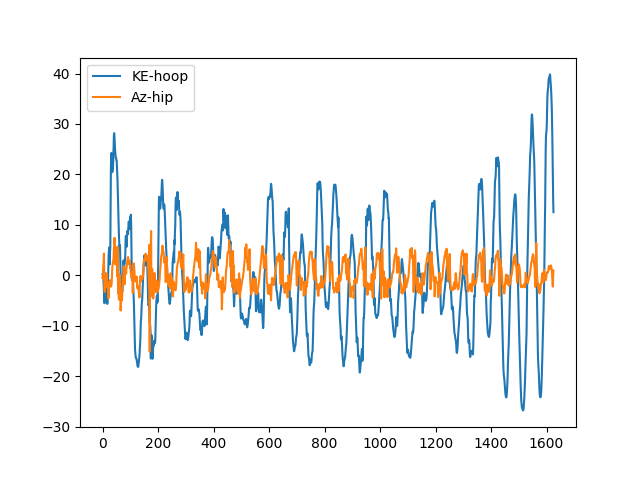

In [29]:
# Plot Energies
fig_E, ax_E = plt.subplots()

sensor  = 0

ax_E.plot(KE_hoop[sensor,active_slice]-np.mean(KE_hoop[sensor,active_slice]), label='KE-hoop')
# ax_E.plot(PE_hoop[sensor,:], label='PE-hoop')
# ax_E.plot(E_hoop[sensor,:], label='E-hoop')

sensor  = 1
# ax_E.plot(KE_hoop[sensor,:], label='KE-hoop')
# ax_E.plot(PE_hoop[sensor,:], label='PE-hoop')
# ax_E.plot(E_hoop[sensor,:], label='E-hoop')

ax_E.plot(IT_Az[active_slice], label='Az-hip')

ax_E.legend()


Do these two signals have the same frequency?

## Smoothing Signal

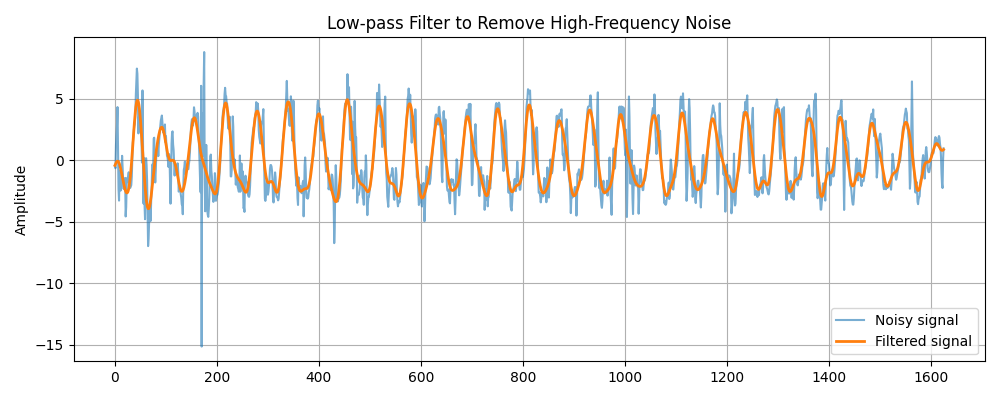

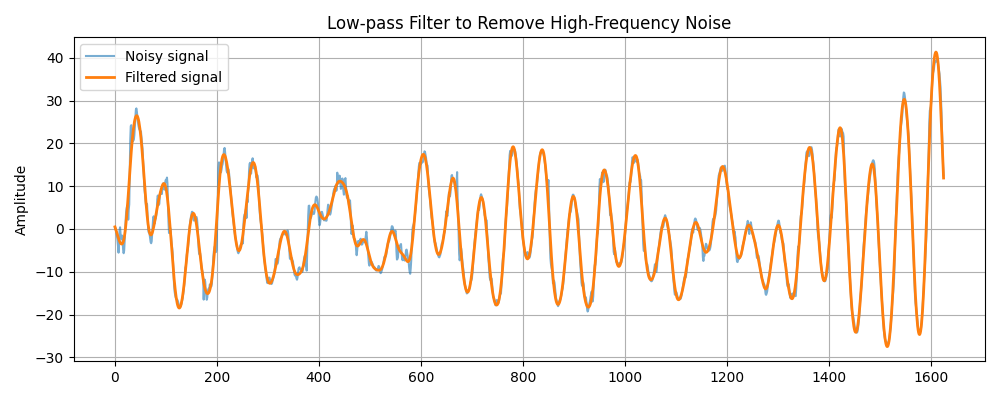

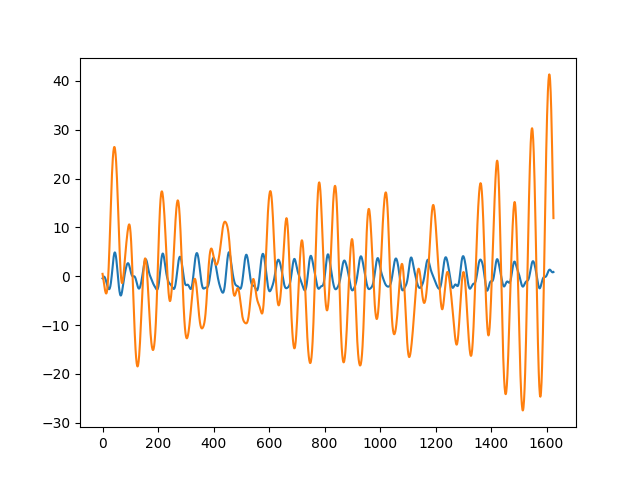

In [45]:
IT_Az_filtered = lowpass_filter(IT_Az[active_slice],5)
KE_hoop_filtered = lowpass_filter(KE_hoop[0,active_slice]-np.mean(KE_hoop[0,active_slice]),5)

fig, ax = plt.subplots()
ax.plot(IT_Az_filtered)
ax.plot(KE_hoop_filtered)

## Finding signal period

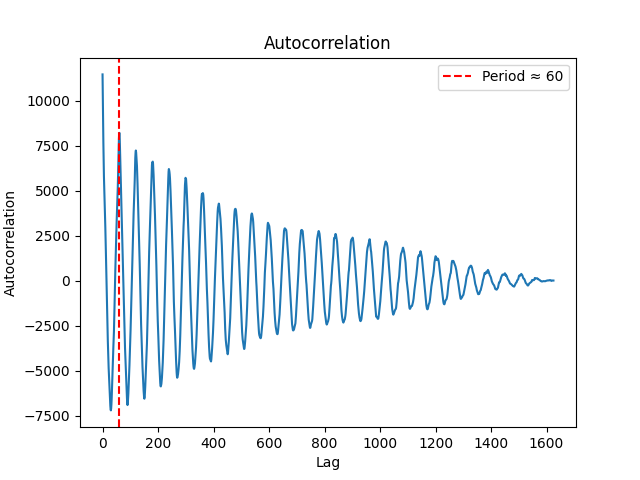

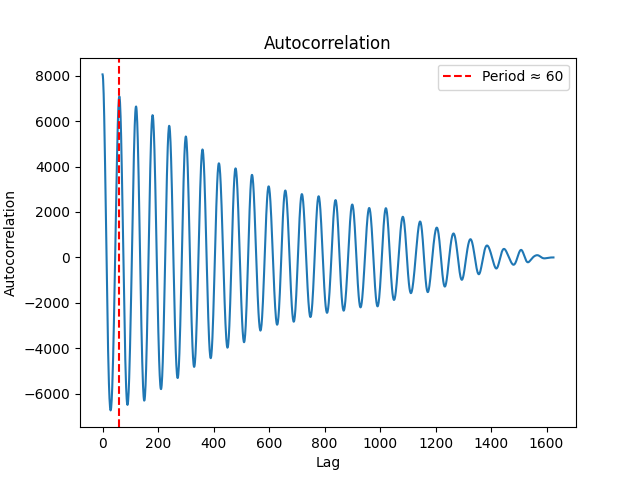

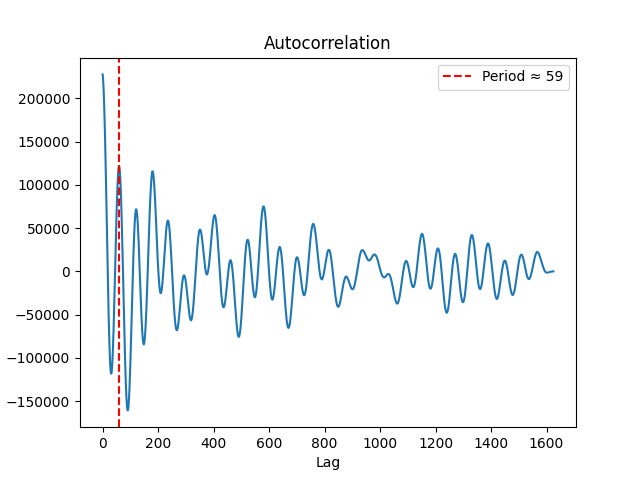

60
0.5
60
0.5
59
0.49166666666666664


In [51]:


Az_period_samples, Az_period_time = estimate_period_autocorr(IT_Az[active_slice], plot=True)
Az_filtered_period_samples, Az_filtered_period_time = estimate_period_autocorr(IT_Az_filtered, plot=True)
KE_period_samples, KE_period_time = estimate_period_autocorr(KE_hoop[0,active_slice], plot=True)

print(Az_period_samples)
print(Az_period_time)

print(Az_filtered_period_samples)
print(Az_filtered_period_time)

print(KE_period_samples)
print(KE_period_time)




# PCA

Which data should we run through PCA? raw data?

shape(X):
(1426, 9)
X_pca:
[[-2.04208264  0.20670099 -0.58383441 ... -0.41434817  0.36855499
  -0.10065728]
 [-2.07802712  0.42937643 -0.51301006 ... -0.29325225  0.13664693
  -0.16162328]
 [-1.9408905   0.68676081 -0.13212069 ... -0.00598249  0.13779074
  -0.181337  ]
 ...
 [-1.2643409  -0.89590394 -0.00711752 ...  0.33238102 -0.76896162
   0.02134133]
 [-1.62809761 -1.12705367  0.0639844  ...  0.39481676 -1.12176286
  -0.07731461]
 [-0.64902397 -0.98184797  0.24703877 ...  0.06333792 -0.25795599
  -0.29719761]]
Eigenvalues:
[3.68880652 2.51180467 0.99456969 0.63578422 0.39500108 0.34928981
 0.24940048 0.14023506 0.04142425]
Eigenvectors (Principal Directions):
[[ 3.28093782e-01  4.43100653e-01 -2.67802086e-01 -2.61292037e-01
   4.42779226e-01  2.45052884e-01  1.34843695e-01 -3.74877234e-01
   3.75772105e-01]
 [ 3.65513517e-01  1.35586173e-01  4.95117041e-01  2.72369196e-01
  -1.37422917e-01  4.38752909e-01 -8.91241149e-02 -3.79000873e-01
  -4.07082857e-01]
 [-6.82265965e-02  5.845375

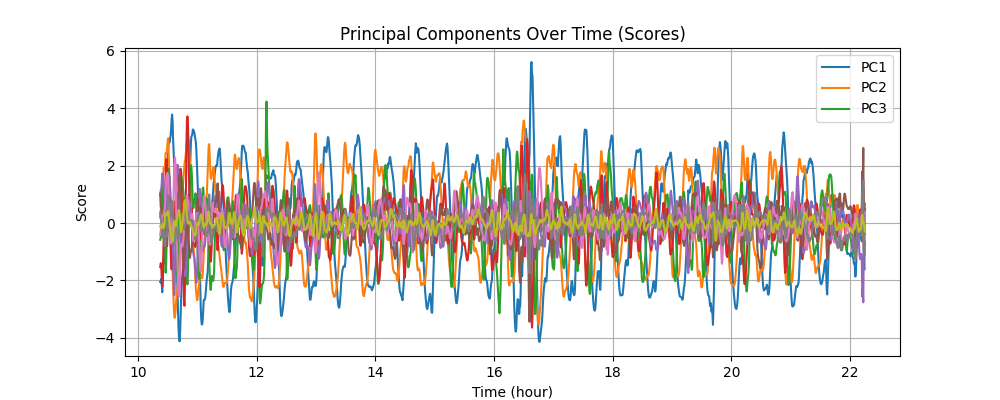

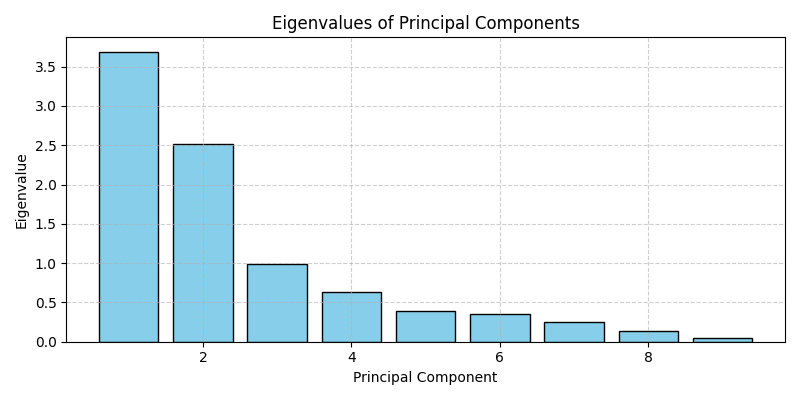

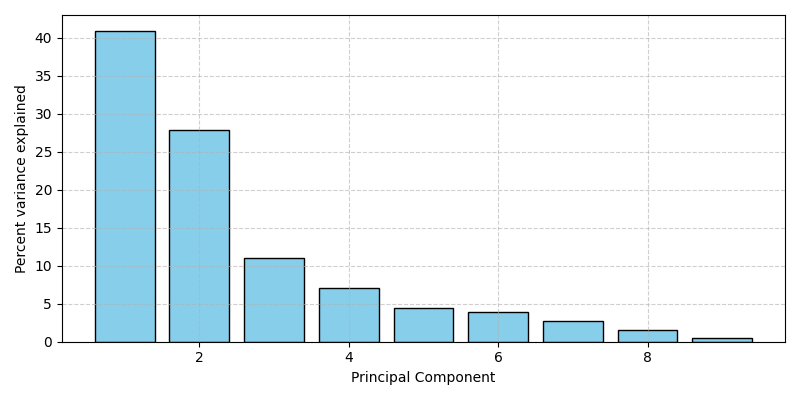

In [77]:
# Step 1: Stack and transpose
# X = np.vstack([
#     OL_accel_x, OL_accel_y, OL_accel_z, OL_phi, OL_theta, OL_psi, OL_wx, OL_wy, OL_wz, 
#     OR_accel_x, OR_accel_y, OR_accel_z, OR_phi, OR_theta, OR_psi, OR_wx, OR_wy, OR_wz, 
#     IT_accel_x, IT_accel_y, IT_accel_z, IT_phi, IT_theta, IT_psi, IT_wx, IT_wy, IT_wz,
#     IL_accel_x, IL_accel_y, IL_accel_z, IL_phi, IL_theta, IL_psi, IL_wx, IL_wy, IL_wz,
#     IB_accel_x, IB_accel_y, IB_accel_z, IB_phi, IB_theta, IB_psi, IB_wx, IB_wy, IB_wz
#     ]).T


X = np.vstack([
    IB_wx[active_slice], IB_wy[active_slice], IB_wz[active_slice],
    IT_wx[active_slice], IT_wy[active_slice], IT_wz[active_slice],
    IL_wx[active_slice], IL_wy[active_slice], IL_wz[active_slice]
    ]).T

# X = np.vstack([
#     IB_psi[active_slice], IB_theta[active_slice], IB_phi[active_slice],
#     IT_psi[active_slice], IT_theta[active_slice], IT_phi[active_slice],
#     IL_psi[active_slice], IL_theta[active_slice], IL_phi[active_slice]
#     ]).T

print('shape(X):')
print(np.shape(X))

# Step 2: Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA
pca = PCA(n_components=np.shape(X)[1])
X_pca = pca.fit_transform(X_scaled)
# Get the eigenvectors (principal directions)
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_
explained_variance_ratio = pca.explained_variance_ratio_

# After fitting PCA

print('X_pca:')
print(X_pca)

print("Eigenvalues:")
print(eigenvalues)

print("Eigenvectors (Principal Directions):")
print(eigenvectors)

# Explained variance ratio
print("Explained Variance Ratio:")
print(explained_variance_ratio)


plt.figure(figsize=(10, 4))
plt.plot(time[active_slice], X_pca)
plt.title("Principal Components Over Time (Scores)")
plt.legend(["PC1", "PC2", "PC3"])
plt.xlabel("Time (hour)")
plt.ylabel("Score")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(range(1, len(eigenvalues) + 1), eigenvalues, color='skyblue', edgecolor='k')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of Principal Components')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio*100, color='skyblue', edgecolor='k')
plt.xlabel('Principal Component')
plt.ylabel('Percent variance explained')
# plt.title('explained_variance_ratio of Principal Components')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [69]:
print(explained_variance_ratio)

[0.40957997 0.27889369 0.11043025 0.07059315 0.04385823 0.03878276
 0.02769173 0.01557075 0.00459947]


In [70]:
np.sum(explained_variance_ratio[:5])

np.float64(0.9133552922455315)

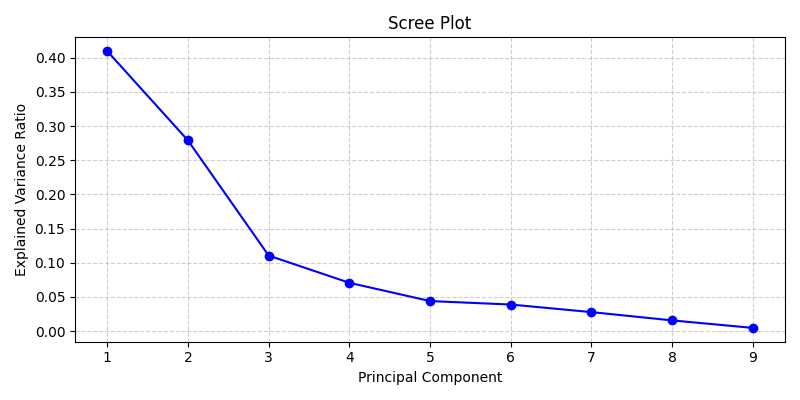

In [60]:
# Plot
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'o-', color='blue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

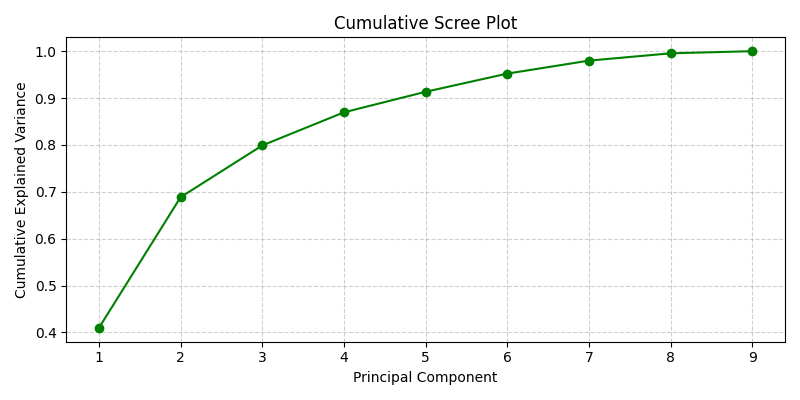

In [61]:
cumulative_variance = explained_variance_ratio.cumsum()

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'o-', color='green')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Scree Plot')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


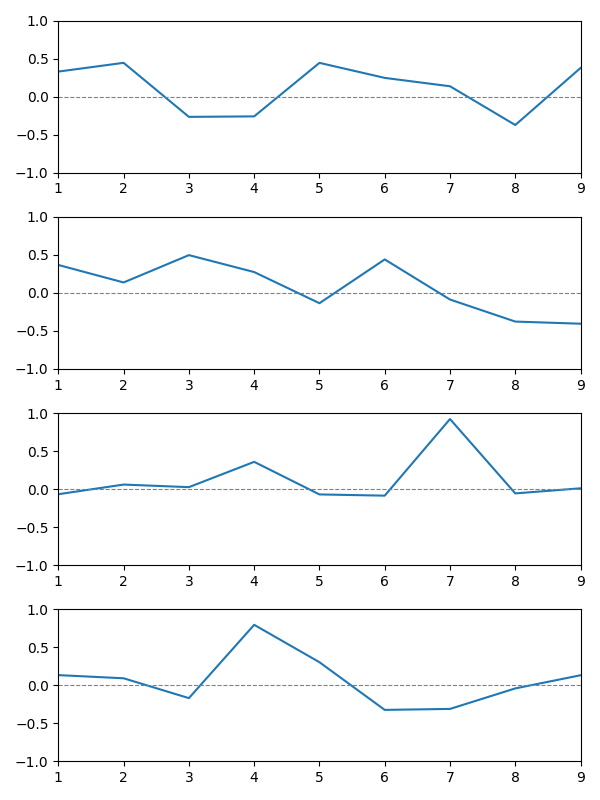

In [55]:

n_rows, n_cols = eigenvectors.shape

n_rows = 4 # overriding, printing top 4 only

fig, ax = plt.subplots(n_rows, 1, figsize=(6, 8))
x_vals = np.arange(1, n_cols + 1)  # X values starting from 1

for i in range(n_rows):
    ax[i].plot(x_vals, eigenvectors[i, :])
    ax[i].axhline(0, color='gray', linestyle='--', linewidth=0.8)
    ax[i].set_xticks(x_vals)
    ax[i].set_xticklabels([f"{x}" for x in x_vals])  # TikZ-style labels: 1, 2, ...
    ax[i].set_xlim(1, n_cols)
    ax[i].set_ylim(-1, 1)

plt.tight_layout()



look at video to see what this kink is due to

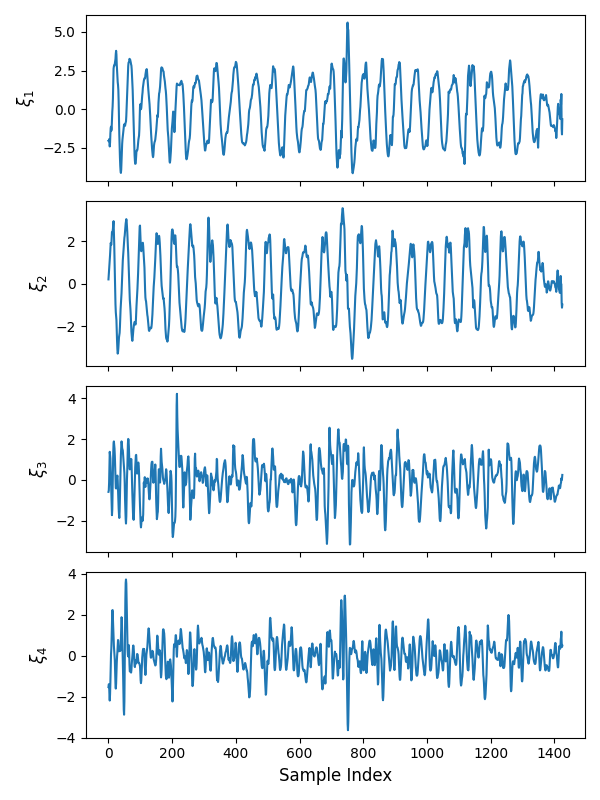

In [75]:
n = 4
fig, ax = plt.subplots(n, 1, figsize=(6, 8), sharex=True)

for i in range(n):
    ax[i].plot(X_pca[:, i])
    ax[i].set_ylabel(rf'$\xi_{{{i+1}}}$', fontsize=12)

ax[-1].set_xlabel('Sample Index', fontsize=12)  # Label x-axis on last subplot
plt.tight_layout()
plt.show()


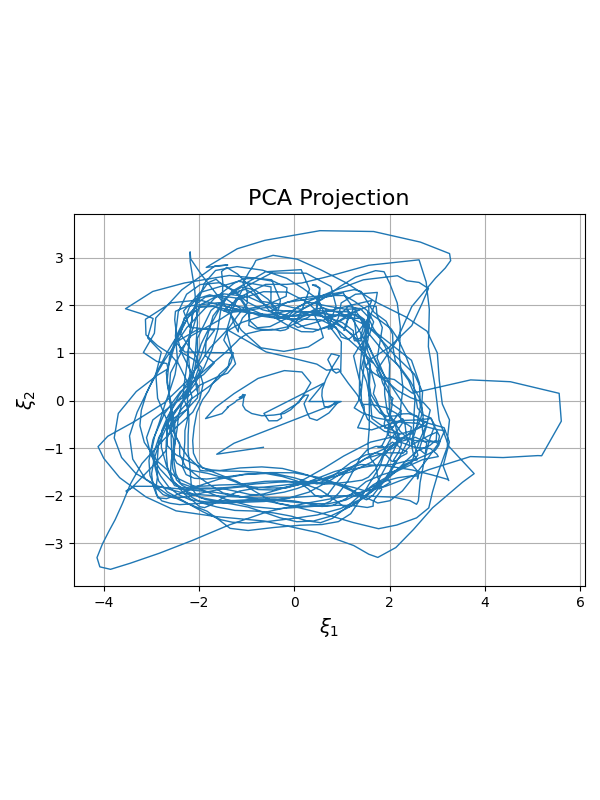

In [72]:
fig, ax = plt.subplots(figsize=(6, 8))
ax.plot(X_pca[:, 0], X_pca[:, 1], lw=1)

ax.set_xlabel(r'$\xi_1$', fontsize=14)
ax.set_ylabel(r'$\xi_2$', fontsize=14)
ax.set_title('PCA Projection', fontsize=16)

ax.grid(True)
ax.set_aspect('equal')  # Optional, depending on your data
plt.tight_layout()
plt.show()



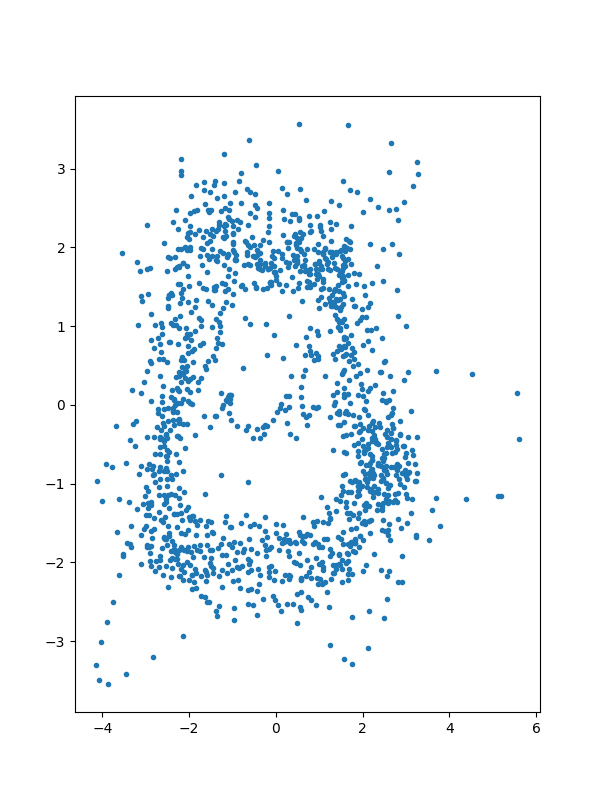

In [66]:
# pca with similar frequency
fig, ax = plt.subplots(figsize=(6, 8))
ax.plot(X_pca[:,0],X_pca[:,1],'.') 

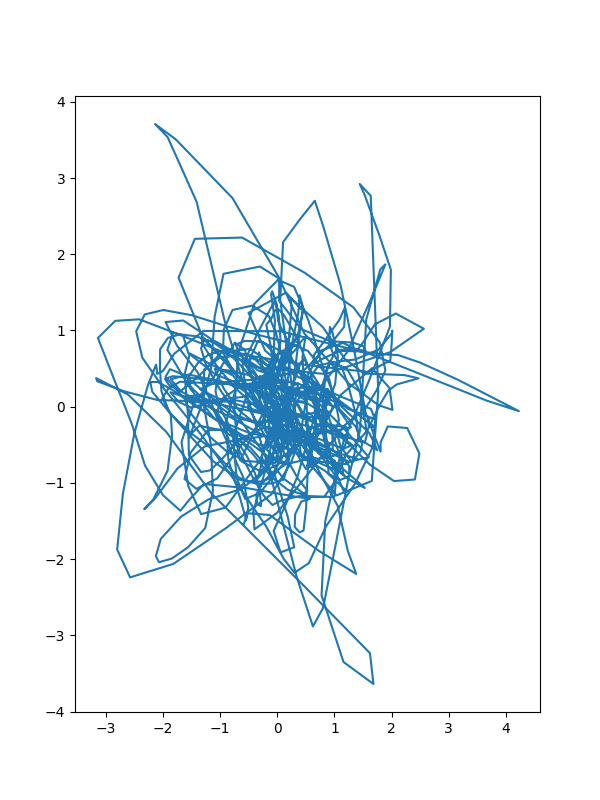

In [83]:
# pca with similar frequency
fig, ax = plt.subplots(figsize=(6, 8))
ax.plot(X_pca[:,2],X_pca[:,3]) 

Read `Daffertshofer et al. PCA in studying coordination and variability: a tutorial` figures 7 and 4. According to these authors, the similar periods could be hinting at oscillations under holonomic constraints. That is, the signals might be functionally related (eg. deffering by a phase) rather than totally independent.

PCA might not be the best method to analyze constrained systems: [see what ChatGPT says about this](https://chatgpt.com/share/688979e2-0ef0-8011-97f9-e46adb3f0616)

Other techniques: 
- Constrained Principal Component Analysis: not very well suited. Read more.
- Network Analysis: https://scholar.google.com/citations?user=_VF_KCQAAAAJ&hl=en&oi=ao

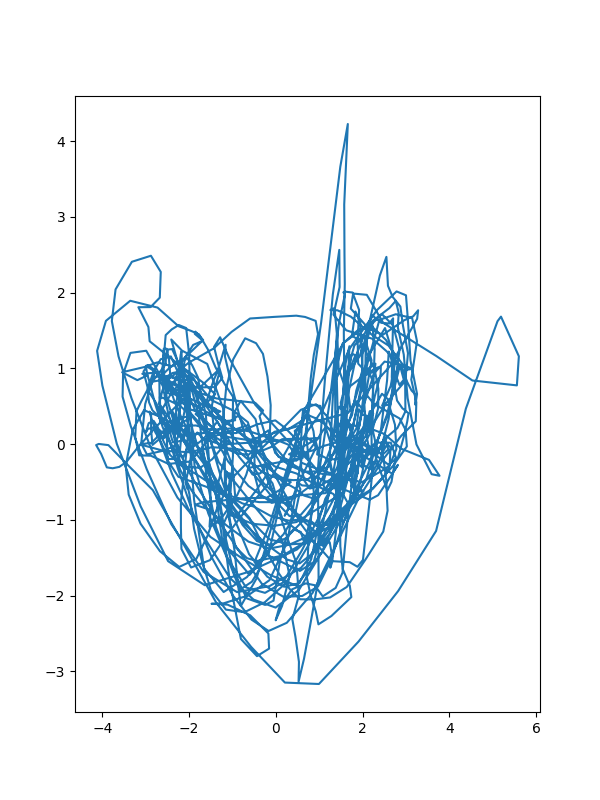

In [79]:
fig, ax = plt.subplots(figsize=(6, 8))
ax.plot(X_pca[:,0],X_pca[:,2]) 

# Moment, Power, and Work

In [148]:
from scipy.integrate import cumulative_simpson as integrate

# Fixed basis
E1 = np.array([1,0,0])
E2 = np.array([0,1,0])
E3 = np.array([0,0,1])

def get_bases(psi,theta,phi):

    n = np.size(psi)

    e1p = np.zeros((3,n))
    e2p = np.zeros((3,n))
    e3p = np.zeros((3,n))

    e1pp = np.zeros((3,n))
    e2pp = np.zeros((3,n))
    e3pp = np.zeros((3,n))

    e1 = np.zeros((3,n))
    e2 = np.zeros((3,n))
    e3 = np.zeros((3,n))

    for i in range(n):
        # First rotation by an angle psi about E3
        e1p[:,i] = np.cos(psi[i])*E1+np.sin(psi[i])*E2
        e2p[:,i] = -np.sin(psi[i])*E1+np.cos(psi[i])*E2
        e3p[:,i] = E3
        # Second rotation by an angle theta about e2p
        e1pp[:,i] = np.cos(theta[i])*e1p[:,i]-np.sin(theta[i])*e3p[:,i]
        e2pp[:,i] = e2p[:,i]
        e3pp[:,i] = np.sin(theta[i])*e1p[:,i]+np.cos(theta[i])*e3p[:,i]
        # Third rotation by an angle phi about e1pp
        e1[:,i] = e1pp[:,i]
        e2[:,i] = np.cos(phi[i])*e2pp[:,i]+np.sin(phi[i])*e3pp[:,i]
        e3[:,i] = -np.sin(phi[i])*e2pp[:,i]+np.cos(phi[i])*e3pp[:,i]

    return e1, e2, e3

def get_moment(wx,wy,wz,e1,e2,e3):
    '''
    Use the balance of angular momentum to calculate the moment about the center of mass.
    The products of inertia are zero.
    MC = dotHC = H_corrotational + cross(omega,HC)
    '''

    # Angular accelerations (derivatives of angular velocities)
    alpha_x = np.gradient(wx, dt)
    alpha_y = np.gradient(wy, dt)
    alpha_z = np.gradient(wz, dt)

    # H_corrotational
    H_corrotational = ICxx*alpha_x*e1+ICyy*alpha_y*e2+ICzz*alpha_z*e3
    # omega_cross_HC
    omega_cross_HC = (ICzz*wy*wz - ICyy*wy*wz)*e1+(ICxx*wx*wz - ICzz*wx*wz)*e2+(ICyy*wx*wy - ICxx*wx*wy)*e3
    # sum of moments about the center of mass
    MC = H_corrotational+omega_cross_HC

    # here MC is expressed in the fixed basis

    # in corrotational basis
    M1 = ICxx*alpha_x+(ICzz*wy*wz - ICyy*wy*wz)
    M2 = ICyy*alpha_y+(ICxx*wx*wz - ICzz*wx*wz)
    M3 = ICzz*alpha_z+(ICyy*wx*wy - ICxx*wx*wy)

    return MC, M1, M2, M3

def get_power(vx,vy,vz,ax,ay,az):
    '''
    Calculate the power of the forces acting on each sensor.
    Power = np.dot(F,v) = np.dot(ma,v)
    '''
    P = m*(ax*vx+ay*vy+az*vz)

    return P

def get_work(power):
    '''
    Work = int(Pdt) = int(np.dot(F,dr))
    @Chrystal. should I detrend?
    '''
    W = detrend(time[2:], integrate(y=power,x=time[1:]), degree=6)
    return W





In [149]:
IL_e1, IL_e2, IL_e3 = get_bases(IL_psi,IL_theta,IL_phi)
IL_MC, IL_M1, IL_M2, IL_M3 = get_moment(IL_wx,IL_wy,IL_wz,IL_e1,IL_e2,IL_e3)
IL_power = get_power(IL_vx,IL_vy,IL_vz,IL_accel_x[1:],IL_accel_y[1:],IL_accel_z[1:])
IL_work = get_work(IL_power)


/var/folders/lg/7kf9vln158j8p2tsj0l79gt00000gp/T/ipykernel_38846/1539270545.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend()
/var/folders/lg/7kf9vln158j8p2tsj0l79gt00000gp/T/ipykernel_38846/1539270545.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()
/var/folders/lg/7kf9vln158j8p2tsj0l79gt00000gp/T/ipykernel_38846/1539270545.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[2].legend()
/var/folders/lg/7kf9vln158j8p2tsj0l79gt00000gp/T/ipykernel_38846/1539270545.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an und

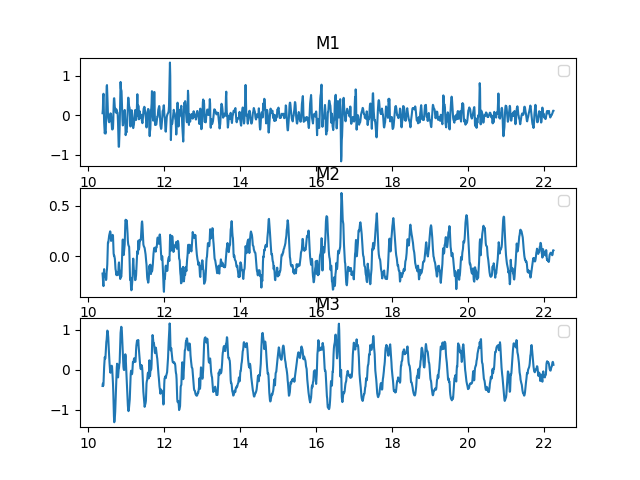

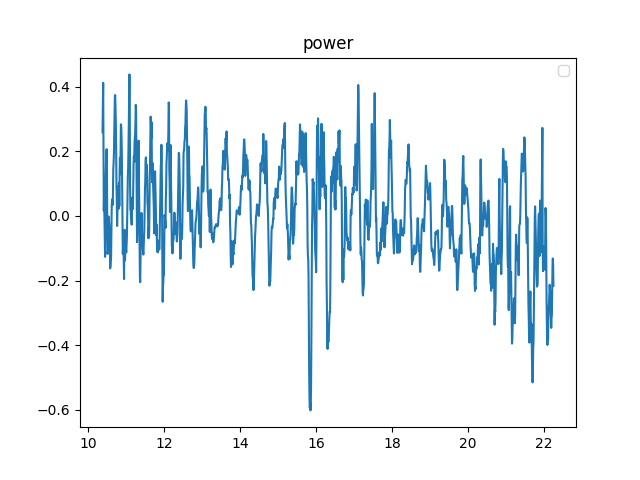

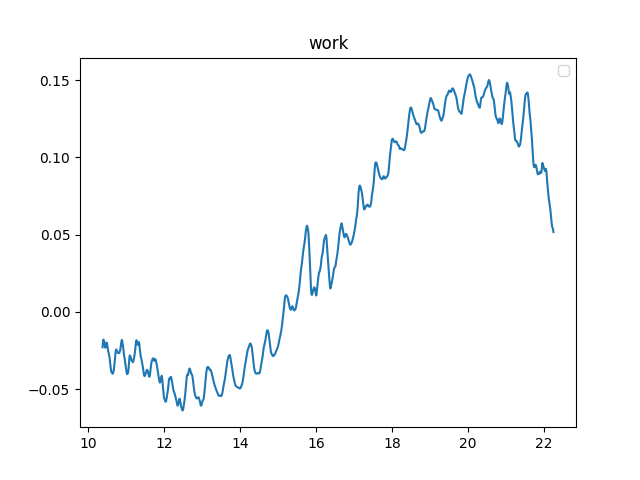

In [150]:
# Plotting raw acceleration data
%matplotlib widget

# moments
fig, ax = plt.subplots(3)  # Creates a 3x1 grid of Axes

ax[0].set_title('M1')
ax[0].plot(time[active_slice], IL_M1[active_slice])
ax[0].legend()

ax[1].set_title('M2')
ax[1].plot(time[active_slice], IL_M2[active_slice])
ax[1].legend()

ax[2].set_title('M3')
ax[2].plot(time[active_slice], IL_M3[active_slice])
ax[2].legend()

# powers
fig, ax = plt.subplots()  # Creates a 3x1 grid of Axes

ax.set_title('power')
ax.plot(time[active_slice], IL_power[active_slice])
ax.legend()

# work
fig, ax = plt.subplots()  # Creates a 3x1 grid of Axes

ax.set_title('work')
ax.plot(time[active_slice], IL_work[active_slice])
ax.legend()




In [147]:
np.shape(IL_power)

(5078,)

In [ ]:
# syms wx real
# syms wy real
# syms wz real

# syms ICxx real
# syms ICyy real
# syms ICzz real

# cross([wx;wy;wz],[ICxx*wx;ICyy*wy;ICzz*wz])

# ICzz*wy*wz - ICyy*wy*wz
# ICxx*wx*wz - ICzz*wx*wz
# ICyy*wx*wy - ICxx*wx*wy